# Обнаружение каверов музыкальных треков

**Описание проекта**

Обнаружение треков каверов - важная продуктовая задача, которая может значительно улучшить качество рекомендаций музыкального сервиса и повысить счастье пользователей. Если суметь с высокой точностью классифицировать каверы и связывать их между собой, то можно предложить пользователю новые возможности для управления потоком треков. Например:

- по желанию пользователя можно полностью исключить каверы из рекомендаций;
- показать все каверы на любимый трек пользователя;
- контролировать долю каверов в ленте пользователя.

Нам предлагается разработать решение, которое:

- может классифицировать треки по признаку кавер-некавер;
- связывать (группировать) каверы и исходный трек;
- находит исходный трек в цепочке каверов.

Совсем не обязательно, чтобы наше решение умело делать все три функции. Будет уже здорово, если мы сможем придумать решение хотя бы для одной задачи.

Для решения этой задачи мы можем использовать любые открытые источники данных и собирать необходимую нам информацию, соблюдая правила использования сервисов, которые эту информацию предоставляют.

## <font size=4>**Описание данных.**

Разметка каверов

Файл `covers.json` содержит разметку каверов, сделанную редакторами сервиса:

- `track_id` - уникальный идентификатор трека;
- `track_remake_type` - метка, присвоенная редакторами. Может принимать значения `ORIGINAL` и `COVER`;
- `original_track_id` - уникальный идентификатор исходного трека.
***
Метаинформация

- `track_id` - уникальный идентификатор трека;
- `dttm` - первая дата появления информации о треке;
- `title` - название трека;
- `language` - язык исполнения;
- `isrc` - международный уникальный идентификатор трека;
- `genres` - жанры;
- `duration` - длительность трека.
***
Текст песен

- `track_id` - уникальный идентификатор трека;
- `lyricId` - уникальный идентификатор текста;
- `text` - текст трека.

***Интро:***
  в данной работе наша команда планирует создание рекомендательной системы подбора треков для пользователей одного из продуктов Яндекс.Музыка. Так как данная задача является задачей классификации, нами также будет проведено обучение и тестирование модели-классификатора.

***План выполнения работ:***
- Изучение и предварительный анализ имеющихся данных, выделение целевого признака
- Предобработка данных:
  - работа с пропусками, дубликатами
  - "очистка" и приведение к единому виду текстовых данных
- Подготовка признаков к обучению:
  - выделение предобработанных признаков из имеющегося набора
  - создание собственных признаков
  - формирование финального набора признаков
- Обучение и валидация модели на сформированном наборе признаков
- Создание алгоритма рекомендательной системы подбора треков для конечного пользователя.

## Библиотеки и загрузки

In [ ]:
!pip install langdetect

In [ ]:
!pip3 install catboost

In [ ]:
!pip install pandarallel

In [ ]:
!pip install -U sentence-transformers

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, normalize
from sklearn.compose import ColumnTransformer
import warnings
from sklearn.metrics import (
    accuracy_score,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    f1_score
    )
import re
import difflib
from catboost import CatBoostClassifier
from langdetect import detect
from pandarallel import pandarallel
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers.util import cos_sim
from scipy.spatial.distance import pdist, squareform

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_color_codes(palette='pastel')
sns.set_palette('pastel', n_colors=10)

In [ ]:
covers = pd.read_json('/content/covers.json', lines=True)

In [ ]:
lyrics = pd.read_json('/content/lyrics.json', lines=True)

In [ ]:
meta = pd.read_json('/content/meta.json', lines=True)

## Анализ датасетов

### Анализ датасета Covers

In [ ]:
covers.sample(15)

,original_track_id,track_id,track_remake_type
63285,None,a19d0f27082bb797c5b95518e5013d35,COVER
38860,None,e0cddacb32bac934d3c0763237f63db0,COVER
66636,None,46a05784f9ba958f2e365f607cc67843,COVER
58215,None,439271852c85318db0414ce385a5f810,COVER
51508,None,37ec8ff2ae951e6a40337177b4714506,COVER
62954,None,604072097603592e1d9d28c289ada7ca,COVER
65372,None,d37d0e7af78d250bdab017983c368496,COVER
34918,None,d834af6958385f3c0a218953faa068c4,COVER
1775,None,15245ad62867238591518b605d0fbc92,COVER
54118,None,e01b211c7d3f5549c1f8198e10185439,COVER


In [ ]:
covers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


In [ ]:
covers['track_remake_type'].value_counts()

COVER       67304
ORIGINAL     4293
Name: track_remake_type, dtype: int64

In [ ]:
covers['original_track_id'].isna().sum()

66776

In [ ]:
miss = []
dupl = []
for i in covers.columns:
    miss.append(covers[i].isna().sum())
    dupl.append(covers[i].nunique())



miss_df = pd.DataFrame({'name' : covers.columns, 'NaN' : miss, 'Unique' : dupl})
miss_df

,name,NaN,Unique
0,original_track_id,66776,4468
1,track_id,0,71597
2,track_remake_type,0,2


**Вывод:** В датасете corvers содержится 71597 строк в 3 колонках. Тип всех данных строковый, присутствуют 66776 пропусков в столбце с id уникального трека(все пропуски относятся к значению столбца с метками COVER), соотвественно в данных практически нет соотнесения оригинальных треков и каверов. Также в данном датасете присутствует целевой признак - track_remake_type

Значения в колонке track_id все уникальные

### Анализ датасета Lyrics

In [ ]:
lyrics.sample(15)

,lyricId,text,track_id
6029,d33501eafa5f65b75da0a4bf5a8577a3,Kiss me hard before you go\nSummertime sadness...,ca1c4cbc9b1cb3197ed5e52df9caf573
10538,b8f84eed2521ad790b8b29849a0d8898,Coloquei uma carta\nNuma velha garrafa\nMas um...,6e1919ef18f0fdabfba1b436b265e87d
979,a3833b2bc69511b70ff9876a8dca8701,Новую жизнь начнем с нуля\nДавай забудем что б...,697f4a1e6b8d7686030dbfd9f4f5806c
5674,ccd57fb8e2a23ad87a90f168b00fe860,Забери мою печаль мадам\nИ никому твое сердце ...,0962fa83ff40d4b574fa3693ff8989da
9049,21dbe9b1aec565b6ee397429c24268f2,Deep in my heart - there's a fire - a burning ...,2dc2fcf346f72428c8408f4947562c79
6703,c61ab87625d276ccb26c466a89194c42,The world was on fire and no one could save me...,3666c5b90b76032e19f3a456387f1414
1147,dbb3c75ede5cf61b0dafa7d710e7490d,Like most babies smell like butter\nHis smell ...,4b589500a28b71b9eeae1fa9ed3a7b3f
5349,a1342e692496feafa1749295a9ec3412,"दुनिया, ज़माने से रिश्ते मिटाए हैं\nतुझ से ही ...",8184a6febfe272ef3156ad6ba177e0b1
7576,d13d0b852f517b721054fc170fd869a0,"Девочка, с которой я долбил косяк (долбил кося...",e275222b842a3743b92df92ae9ab8df5
10385,2e159668c85d77386e9bf64eecab0f5f,Пусть бегут неуклюже\nПешеходы по лужам\nА вод...,9aac5a0413e65a16991bc7770fb22926


In [ ]:
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


In [ ]:
lyrics['track_id'].value_counts()

b891000882f4a612190142861b5c038b    24
adc126c946551da4e1784e716b77992e    17
f0f429d03fdd19f08ff60e889e32aae2    16
951edd96627f47b783716a54d2368d7b    12
ca1c4cbc9b1cb3197ed5e52df9caf573    12
                                    ..
f4d64771c9859a7c24c9fd4e513b0173     1
044c9caa72f85c15f0e4cde5d1906957     1
1baad2f02b10ae48aa0457386ef7c3fe     1
32436073f567a7afd699bb9261c89b51     1
c860754a50dac664d847bca85e6897f4     1
Name: track_id, Length: 10277, dtype: int64

In [ ]:
lyrics.duplicated().sum()

0

In [ ]:
miss = []
dupl = []
for i in lyrics.columns:
    miss.append(lyrics[i].isna().sum())
    dupl.append(lyrics[i].nunique())



miss_df = pd.DataFrame({'name' : lyrics.columns, 'NaN' : miss, 'Unique' : dupl})
miss_df['Duplicates'] = 11414 - miss_df['Unique']
miss_df

,name,NaN,Unique,Duplicates
0,lyricId,0,10915,499
1,text,0,10644,770
2,track_id,0,10277,1137


**Вывод**: В датасете lyrics содержится 11414 строки. Пропуски в данных отсутствуют, однако имеется много повторов. Так в поле текст содержится 10644 уникальных записи и 770 дубликатов. В лирик id 10915 уникальных записей и 499 дубликатов, track_id имеет 10277 уникальных номера и 1137 повторов.

In [ ]:
lyrics.loc[(lyrics['track_id'] == 'b891000882f4a612190142861b5c038b')]

,lyricId,text,track_id
1800,6510c50bec7a64a02a3a198793d81f2b,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
1814,5de2a48ffe755a226704bb6db2f1b743,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
3360,89d690b2da9a4827cfd9f1fa088ec207,"La, la, la, la, la, la, la, la, la, la, la, la...",b891000882f4a612190142861b5c038b
5304,1a6450a439b4d385b40f3077d308e01a,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
6007,3aa4b1682c24f8ce982245856da157d6,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
6175,5fdc9a316a05bca8a5d6b1d5da453659,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
6535,66183e0ff8df93904f9f67b63e6980d9,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
7595,11ba6102483116158e814fcc7bbdc55e,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
7601,504c9590913941d22dd49124f63d4d5e,La lalala lala lalala lala\nLa lalala lala lal...,b891000882f4a612190142861b5c038b
7602,913ae25eda32c1b63d180562d65fade2,La lalala lala lalala lala\nLa lalala lala lal...,b891000882f4a612190142861b5c038b


**Вывод:** В текстах песен есть как полные повторы, так и тексты отличающиеся - знаками препинаний, количеством повторов припева, где-то есть различия в текстах.
Полные дубли я приняла решение сразу удалить.
Для анализа в дальнейшем не нужна будет колонка lyricId

In [ ]:
lyrics = lyrics.drop('lyricId', axis=1)
lyrics.shape

(11414, 2)

Посчитаем полные дубли

In [ ]:
lyrics.duplicated().sum()

264

In [ ]:
lyrics = lyrics.drop_duplicates()
lyrics.shape

(11150, 2)

In [ ]:
lyrics.loc[(lyrics['track_id'] == 'b891000882f4a612190142861b5c038b')]

,text,track_id
1800,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
1814,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
3360,"La, la, la, la, la, la, la, la, la, la, la, la...",b891000882f4a612190142861b5c038b
6175,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
6535,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
7601,La lalala lala lalala lala\nLa lalala lala lal...,b891000882f4a612190142861b5c038b
9004,"La, la, la, la, la, la, la\nLa, la, la, la, la...",b891000882f4a612190142861b5c038b


Посчитаем уникальные track_id песен

In [ ]:
count_dup = lyrics['track_id'].value_counts().to_frame()
count_dup['track_id'].value_counts()

1     9693
2      426
3       90
4       34
5       19
7        6
6        6
8        2
10       1
Name: track_id, dtype: int64

**Вывод:** В датасете лирик большая часть песен встречается 1 раз - 9693 треков. 1457 текстов относятся к повторяющимся track_id

### Анализ датасета Meta

In [ ]:
meta.sample(15)

,track_id,dttm,title,language,isrc,genres,duration
16445,a7b4760157b9040b26884914ee77f4cc,1.569448e+12,Gaiola É o Troco,None,QZHZ31994140,"[FOREIGNRAP, RAP]",110610.0
3003,989891d44883892870375bb531003955,1.641598e+12,Meu Doce Amor,None,US7VG2222527,"[FOLK, LATINFOLK]",217330.0
45574,9c83520011200f9d08fe6e9695ce1ae6,1.288006e+12,Never Gonna Be The Same,None,USA370671918,"[FOLK, LATINFOLK]",231990.0
62458,4d510fcb72a6507cf079a1fbd8635779,1.614108e+12,Leviana,None,US7VG2179628,"[FOLK, LATINFOLK]",246510.0
14705,3392f614c4e32656dda0aba65f033f77,1.660274e+12,Memories,None,QZNJY2259484,[ALTERNATIVE],171140.0
65184,2344c5f5787398caf1b725b7703d40c5,1.617257e+12,How Insensitive,None,QZGLS2159202,"[FOLK, LATINFOLK]",143040.0
68592,2f0eee0eba9f698572e159adca374ef1,1.549048e+12,Feel It Still,None,PLS921748387,[],209620.0
58162,e1a5490c474793ed6f97f3ae6422de22,1.605886e+12,Auroras de Mi Patria,None,QZNJW2073114,[CHILDREN],61530.0
7566,23577b83ee890b288f7d54c0c0f17fd3,1.647223e+12,The Cry Of The Mideast,EN,QZES52298748,[RAP],197480.0
59182,b24759dca05393826e23d38bcf7fe1a9,1.608043e+12,Feels Like Summer,EN,DGA052027167,[POP],29820.0


In [ ]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB


In [ ]:
meta.describe(include='all')

,track_id,dttm,title,language,isrc,genres,duration
count,71768,7.176800e+04,71768,21969,71455,71768,7.176800e+04
unique,71768,NaN,45462,85,71283,232,NaN
top,c3b9d6a354ca008aa4518329aaa21380,NaN,Morena,EN,USTCF1018560,"[FOLK, LATINFOLK]",NaN
freq,1,NaN,81,15322,3,18391,NaN
mean,NaN,1.584287e+12,NaN,NaN,NaN,NaN,2.049187e+05
std,NaN,9.113923e+10,NaN,NaN,NaN,NaN,8.559854e+04
min,NaN,1.249926e+12,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,1.570141e+12,NaN,NaN,NaN,NaN,1.613700e+05
50%,NaN,1.620405e+12,NaN,NaN,NaN,NaN,1.993950e+05
75%,NaN,1.637050e+12,NaN,NaN,NaN,NaN,2.390700e+05


In [ ]:
meta['isrc'].value_counts().sort_values()

QZNJY2034152    1
QZNJZ2175511    1
QZNJZ2175512    1
QZNJZ2175513    1
QZNJZ2176579    1
               ..
INUM70900046    2
USM951900014    2
FR33T0819525    3
USTCF1017794    3
USTCF1018560    3
Name: isrc, Length: 71283, dtype: int64

In [ ]:
meta['track_id'].duplicated().sum()

0

In [ ]:
meta['language'].value_counts()

EN    15322
ES     1747
RU     1558
IT      907
HI      285
      ...  
BM        1
TN        1
AB        1
NY        1
IU        1
Name: language, Length: 85, dtype: int64

In [ ]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB


In [ ]:
meta.tail(15)

,track_id,dttm,title,language,isrc,genres,duration
71754,51d53b670205158abd2eb266fd44c50b,1.560227e+12,B.O.P.,None,QZGLM1908253,[PUNK],123430.0
71755,6bc5b6d04b1a96089ffe677440e059ec,1.560227e+12,Police Story,None,QZGLM1908256,[PUNK],133120.0
71756,5708c1851ae25d75038fe1522009eeca,1.560270e+12,El Angel Que Quiero Yo,None,QZGLM1906110,"[FOLK, LATINFOLK]",227190.0
71757,74e0e689408fe2449a70490dbfe7011e,1.560278e+12,Laços de Amor,None,QZGLM1907749,[SPIRITUAL],259000.0
71758,a95d976c7342f213a2d50a8c9d6c32a8,1.560281e+12,High Hopes,None,ES71G1408071,"[ROCK, ALLROCK]",582860.0
71759,27338fa59732e7b6a6f89ea3e9cf7611,1.560281e+12,Little Wing,None,ES71G1408072,"[ROCK, ALLROCK]",190320.0
71760,e3899173fcdfbd30ff0b07c7e0dbdbc8,1.561064e+12,Shutter Island,None,CAB391902526,[ALTERNATIVE],206650.0
71761,86f1aff8c191baf6957fcda82fe6b3c3,1.560892e+12,Diamonds,None,ES50A1900470,"[ELECTRONICS, HOUSE]",281980.0
71762,495babc700c0c6b5b8549d49f163d3cb,1.625346e+12,Stay With Me,EN,GBKPL1955058,"[JAZZ, VOCALJAZZ]",152090.0
71763,496e3bddf448fbedab6a0825382618c4,1.560399e+12,Se Preparó,None,FR2X41997633,"[FOLK, LATINFOLK]",186340.0


In [ ]:
meta = meta.dropna(subset=['track_id'], axis=0)

Открыт датасет meta, содержащий 71769 строк и 3 столбца с данными(2 из которых имеют численный и 5 строковый тип данных), в данных присутствуют пропуски: в значительном количестве в данных об языке исполнения(49800), 314 строк пропущены в международном ID трека, также присутствует одна абсолютно пустая строка(44434), она будет удалена

#### Разбираемся с жанрами.

В колонке genres - жанры, все строки заполнены, при этом 232 уникальных значения, однако есть переcечения по смыслу и количество уникальных жанров имеет смысл сократить.

In [ ]:
meta['genres'].value_counts()

[FOLK, LATINFOLK]                     18391
[POP]                                 13157
[ROCK, ALLROCK]                        5898
[ALTERNATIVE]                          3570
[FOLK]                                 2645
                                      ...  
[BOOKSNOTINRUSSIAN]                       1
[POP, SPIRITUAL]                          1
[BLUES, RAP]                              1
[FOLK, FOREIGNRAP, RAP, LATINFOLK]        1
[ROCK, ALLROCK, FOLKGENRE]                1
Name: genres, Length: 232, dtype: int64

In [ ]:
#meta = meta.explode('genres')
#meta.head()

In [ ]:
# Функция для преобразования списка в строку
def list_to_string(genre_list):
    if genre_list is not None:
        str_list = [str(genre) for genre in genre_list]
        return ', '.join(str_list)
    else:
        return ''

In [ ]:
# преобразуем список значений в meta['genres'] в строку
meta['genres'] = meta['genres'].apply(list_to_string)
meta

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,DANCE,161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,ELECTRONICS,362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"FOLK, LATINFOLK",260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"FOLK, LATINFOLK",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"FOLK, LATINFOLK",203000.0
...,...,...,...,...,...,...,...
71764,4be93dea1715e54db86aaa7f7e9bfb10,1.560403e+12,Chanceuse,FR,CAISO1800023,INDIE,212690.0
71765,7cba0f30eaa8766d6c203eff2f3750a2,1.560433e+12,Quiero Que Vuelvas,None,ES71G1738868,POP,237540.0
71766,26b6aca1c6a02ad0e2a939164716657e,1.560448e+12,Vacation,EN,USA2B1511447,ALTERNATIVE,215210.0
71767,d904dda141238e6ad1b428bfbb21262d,1.560448e+12,Dance Hall Days,EN,USA2B1511448,ALTERNATIVE,251010.0


In [ ]:
meta['genres'].nunique()

232

In [ ]:
# объединяем все строки в Series в одну строку, разделенную запятыми
genre_string = meta['genres'].str.cat(sep=',')
# разделение строки по запятым
genre_list = genre_string.split(',')
# удаление пробелов и преобразование в нижний регистр
cleaned_genres = [genre.strip().lower()
                  for genre in genre_list if genre.strip()]
# преобразование в множество для уникальности и обратное преобразование в список
unique_genres = list(set(cleaned_genres))
# сортировка списка по алфавиту
unique_genres.sort()
# считаем количество уникальных жанров
num_genres = len(unique_genres)
print(f"Количество жанров: {num_genres}")
# вывод уникальных жанров, отсортированных по алфавиту
unique_genres

Количество жанров: 128


['african',
 'allrock',
 'alternative',
 'alternativemetal',
 'ambientgenre',
 'amerfolk',
 'animated',
 'animemusic',
 'arabesquemusic',
 'arabicpop',
 'asiapop',
 'azerbaijanpop',
 'balkan',
 'bard',
 'bassgenre',
 'bebopgenre',
 'bigbands',
 'blackmetal',
 'blues',
 'bollywood',
 'booksnotinrussian',
 'breakbeatgenre',
 'caucasian',
 'celtic',
 'children',
 'classical',
 'classicalmasterpieces',
 'classicalmusic',
 'classicmetal',
 'conjazz',
 'country',
 'dance',
 'deathmetal',
 'disco',
 'dnb',
 'doommetal',
 'dub',
 'dubstep',
 'eastern',
 'edmgenre',
 'electronics',
 'epicmetal',
 'estrada',
 'eurofolk',
 'experimental',
 'extrememetal',
 'fairytales',
 'films',
 'folk',
 'folkgenre',
 'folkmetal',
 'folkrock',
 'forchildren',
 'foreignbard',
 'foreignrap',
 'funk',
 'gothicmetal',
 'hardcore',
 'hardrock',
 'house',
 'hyperpopgenre',
 'idmgenre',
 'indie',
 'industrial',
 'israelipop',
 'israelirock',
 'japanesepop',
 'jazz',
 'jewish',
 'kpop',
 'latinfolk',
 'local-indie',
 '

In [ ]:
# Приводим значения столбца 'genres' к нижнему регистру и удаляем пробелы
meta['genres'] = meta['genres'].str.replace(' ', '').str.lower()
meta

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,dance,161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,electronics,362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"folk,latinfolk",260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"folk,latinfolk",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"folk,latinfolk",203000.0
...,...,...,...,...,...,...,...
71764,4be93dea1715e54db86aaa7f7e9bfb10,1.560403e+12,Chanceuse,FR,CAISO1800023,indie,212690.0
71765,7cba0f30eaa8766d6c203eff2f3750a2,1.560433e+12,Quiero Que Vuelvas,None,ES71G1738868,pop,237540.0
71766,26b6aca1c6a02ad0e2a939164716657e,1.560448e+12,Vacation,EN,USA2B1511447,alternative,215210.0
71767,d904dda141238e6ad1b428bfbb21262d,1.560448e+12,Dance Hall Days,EN,USA2B1511448,alternative,251010.0


In [ ]:
# объединяем все строки в Series в одну строку, разделенную запятыми
genre_string = meta['genres'].str.cat(sep=',')
# разделение строки по запятым
genre_list = genre_string.split(',')
# удаление пробелов и преобразование в нижний регистр
cleaned_genres = [genre.strip().lower()
                  for genre in genre_list if genre.strip()]
# преобразование в множество для уникальности и обратное преобразование в список
unique_genres = list(set(cleaned_genres))
# сортировка списка по алфавиту
unique_genres.sort()
# считаем количество уникальных жанров
num_genres = len(unique_genres)
print(f"Количество жанров: {num_genres}")
# вывод уникальных жанров, отсортированных по алфавиту
unique_genres

Количество жанров: 128


['african',
 'allrock',
 'alternative',
 'alternativemetal',
 'ambientgenre',
 'amerfolk',
 'animated',
 'animemusic',
 'arabesquemusic',
 'arabicpop',
 'asiapop',
 'azerbaijanpop',
 'balkan',
 'bard',
 'bassgenre',
 'bebopgenre',
 'bigbands',
 'blackmetal',
 'blues',
 'bollywood',
 'booksnotinrussian',
 'breakbeatgenre',
 'caucasian',
 'celtic',
 'children',
 'classical',
 'classicalmasterpieces',
 'classicalmusic',
 'classicmetal',
 'conjazz',
 'country',
 'dance',
 'deathmetal',
 'disco',
 'dnb',
 'doommetal',
 'dub',
 'dubstep',
 'eastern',
 'edmgenre',
 'electronics',
 'epicmetal',
 'estrada',
 'eurofolk',
 'experimental',
 'extrememetal',
 'fairytales',
 'films',
 'folk',
 'folkgenre',
 'folkmetal',
 'folkrock',
 'forchildren',
 'foreignbard',
 'foreignrap',
 'funk',
 'gothicmetal',
 'hardcore',
 'hardrock',
 'house',
 'hyperpopgenre',
 'idmgenre',
 'indie',
 'industrial',
 'israelipop',
 'israelirock',
 'japanesepop',
 'jazz',
 'jewish',
 'kpop',
 'latinfolk',
 'local-indie',
 '

In [ ]:
# Функция для удаления части из каждой строки в столбце.
def remove_part(df, word):
    # Функция для обработки каждого значения жанра
    def clean_genre(genre):
        # Разделяем значение жанра на части
        parts = genre.split()
        # Создаем новый список
        filtered_parts = []
        for part in parts:
            # Проверяем, содержится ли заданная часть в текущей части
            if word in part:
                # Удаляем заданную часть, заменяя ее пустой строкой
                new_part = part.replace(word, '')
                # Проверяем, начинается ли новая часть со знака запятой
                if new_part.startswith(','):
                    # Если да, удаляем запятую, отсекая первый символ
                    new_part = new_part[1:]
                # Добавляем обновленную часть в список
                filtered_parts.append(new_part)
            else:
                # Если заданная часть не найдена, добавляем текущую часть без изменений
                filtered_parts.append(part)
# Объединяем обновленные части в одну строку с пробелами, если они существуют, иначе возвращаем пустую строку
        return ' '.join(filtered_parts) if filtered_parts else ''

    updated_genres = df['genres'].apply(clean_genre)
    df['genres'] = updated_genres
    return df

In [ ]:
remove_part(meta, 'latin')
remove_part(meta, 'rus')
remove_part(meta, 'turkish')
remove_part(meta, 'uzbek')
remove_part(meta, 'asia')
remove_part(meta, 'azerbaijan')
remove_part(meta, 'azerbaijan')
remove_part(meta, 'euro')
remove_part(meta, 'foreign')
remove_part(meta, 'israeli')
remove_part(meta, 'japanese')
remove_part(meta, 'uk')
remove_part(meta, 'amer')
remove_part(meta, 'trad')
remove_part(meta, 'arabic')

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,dance,161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,electronics,362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"folk,folk",260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"folk,folk",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"folk,folk",203000.0
...,...,...,...,...,...,...,...
71764,4be93dea1715e54db86aaa7f7e9bfb10,1.560403e+12,Chanceuse,FR,CAISO1800023,indie,212690.0
71765,7cba0f30eaa8766d6c203eff2f3750a2,1.560433e+12,Quiero Que Vuelvas,None,ES71G1738868,pop,237540.0
71766,26b6aca1c6a02ad0e2a939164716657e,1.560448e+12,Vacation,EN,USA2B1511447,alternative,215210.0
71767,d904dda141238e6ad1b428bfbb21262d,1.560448e+12,Dance Hall Days,EN,USA2B1511448,alternative,251010.0


In [ ]:
# Функция для замены части из каждого значения в столбце
def remove_from_df(df, word, replacement):
    # Функция для обработки каждого значения жанра
    def clean_genre(genre):
        # Разделяем значение жанра на отдельные части
        parts = genre.split()
        # Создаем пустой список
        updated_parts = []
        # Итерируемся по каждой части
        for part in parts:
            # Проверяем, содержание
            if word in part:
                # Заменяем
                new_part = part.replace(word, replacement)
                # Добавляем обновленную часть в список обновленных частей
                updated_parts.append(new_part)
            else:
                # Если нет изменений, добавляем без изменений
                updated_parts.append(part)
                # Объединяем обновленные части
        return ' '.join(updated_parts) if updated_parts else ''

    updated_genres = df['genres'].apply(clean_genre)
    df['genres'] = updated_genres

    return df

In [ ]:
remove_from_df(meta, 'bards', 'bard')
remove_from_df(meta, 'classicalmasterpieces', 'classical')
remove_from_df(meta, 'classicalmusic', 'classical')
remove_from_df(meta, 'dub', 'dubstep')
remove_from_df(meta, 'folkgenre', 'folk')
remove_from_df(meta, 'forchildren', 'children')
remove_from_df(meta, 'poemsforchildren', 'children')
remove_from_df(meta, 'poemschildren', 'children')
remove_from_df(meta, 'local-indie', 'indie')
remove_from_df(meta, 'reggaeton', 'reggae')
remove_from_df(meta, 'rrock', 'rock')
remove_from_df(meta, 'tvseries', 'soundtrack')
remove_from_df(meta, 'films', 'soundtrack')
remove_from_df(meta, 'dubstepstep', 'dubstep')
remove_from_df(meta, 'allrock', 'rock')

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,dance,161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,electronics,362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"folk,folk",260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"folk,folk",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"folk,folk",203000.0
...,...,...,...,...,...,...,...
71764,4be93dea1715e54db86aaa7f7e9bfb10,1.560403e+12,Chanceuse,FR,CAISO1800023,indie,212690.0
71765,7cba0f30eaa8766d6c203eff2f3750a2,1.560433e+12,Quiero Que Vuelvas,None,ES71G1738868,pop,237540.0
71766,26b6aca1c6a02ad0e2a939164716657e,1.560448e+12,Vacation,EN,USA2B1511447,alternative,215210.0
71767,d904dda141238e6ad1b428bfbb21262d,1.560448e+12,Dance Hall Days,EN,USA2B1511448,alternative,251010.0


In [ ]:
# объединяем все строки в Series в одну строку, разделенную запятыми
genre_string = meta['genres'].str.cat(sep=',')
# разделение строки по запятым
genre_list = genre_string.split(',')
# удаление пробелов и преобразование в нижний регистр
cleaned_genres = [genre.strip().lower()
                  for genre in genre_list if genre.strip()]
# преобразование в множество для уникальности и обратное преобразование в список
unique_genres = list(set(cleaned_genres))
# сортировка списка по алфавиту
unique_genres.sort()
# считаем количество уникальных жанров
num_genres = len(unique_genres)
print(f"Количество жанров: {num_genres}")
# вывод уникальных жанров, отсортированных по алфавиту
unique_genres

Количество жанров: 94


['african',
 'alternative',
 'alternativemetal',
 'ambientgenre',
 'animated',
 'animemusic',
 'arabesquemusic',
 'balkan',
 'bard',
 'bassgenre',
 'bebopgenre',
 'bigbands',
 'blackmetal',
 'blues',
 'bollywood',
 'booksnotinsian',
 'breakbeatgenre',
 'caucn',
 'celtic',
 'children',
 'classical',
 'classicmetal',
 'conjazz',
 'country',
 'dance',
 'deathmetal',
 'disco',
 'dnb',
 'doommetal',
 'dubstep',
 'eastern',
 'edmgenre',
 'electronics',
 'epicmetal',
 'esa',
 'experimental',
 'extrememetal',
 'fairytales',
 'folk',
 'folkmetal',
 'folkrock',
 'funk',
 'gothicmetal',
 'hardcore',
 'hardrock',
 'house',
 'hyperpopgenre',
 'idmgenre',
 'indie',
 'industrial',
 'jazz',
 'jewish',
 'kpop',
 'lounge',
 'lullaby',
 'meditation',
 'metal',
 'metalcoregenre',
 'mizrahi',
 'modern',
 'musical',
 'newage',
 'newwave',
 'numetal',
 'phonkgenre',
 'pop',
 'posthardcore',
 'postmetal',
 'postpunk',
 'prog',
 'progmetal',
 'punk',
 'rap',
 'reggae',
 'relax',
 'rnb',
 'rnr',
 'rock',
 'shan

In [ ]:
# Функция для удаления повторяющихся значений в каждой ячейке
def remove_duplicates(cell_value):
    values = cell_value.split(',')
    unique_values = list(set(values))
    return ','.join(unique_values)

# Применение функции к колонке
meta['genres'] = meta['genres'].apply(remove_duplicates)

meta

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,dance,161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,electronics,362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,folk,260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,folk,190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,folk,203000.0
...,...,...,...,...,...,...,...
71764,4be93dea1715e54db86aaa7f7e9bfb10,1.560403e+12,Chanceuse,FR,CAISO1800023,indie,212690.0
71765,7cba0f30eaa8766d6c203eff2f3750a2,1.560433e+12,Quiero Que Vuelvas,None,ES71G1738868,pop,237540.0
71766,26b6aca1c6a02ad0e2a939164716657e,1.560448e+12,Vacation,EN,USA2B1511447,alternative,215210.0
71767,d904dda141238e6ad1b428bfbb21262d,1.560448e+12,Dance Hall Days,EN,USA2B1511448,alternative,251010.0


In [ ]:
meta['genres'].nunique()

189

In [ ]:
meta['genres'].value_counts()

folk                  21284
pop                   14823
rock                   6213
alternative            3570
rap                    2509
                      ...  
folkrock,pop,rock         1
pop,punk,rock             1
spiritual,rock            1
jazz,pop,vocaljazz        1
bard,rock                 1
Name: genres, Length: 189, dtype: int64

По итогам обработки жанров выделено 94 уникальных жанра, из-за их комбинаций в колонке стало 189 уникальныз значений вместо 234 до начала работы. Это позволит улучшить систему предложений.

## Обьединение датасетов meta и covers и предобработка данных:

In [ ]:
data = covers.merge(meta, on='track_id')

In [ ]:
data.shape

(71597, 9)

Приведем дату к более удобному формату

In [ ]:
data.dttm = pd.to_datetime(data.dttm, unit='ms')

In [ ]:
data.dttm = data.dttm.dt.to_period('M').dt.to_timestamp('M')

In [ ]:
data.dttm.value_counts().to_frame(name='Дата появления информации:')

,Дата появления информации:
2021-09-30,3368
2021-08-31,3273
2021-07-31,2882
2021-10-31,2874
2021-06-30,2580
...,...
2010-07-31,3
2011-10-31,3
2010-04-30,2
2011-02-28,2


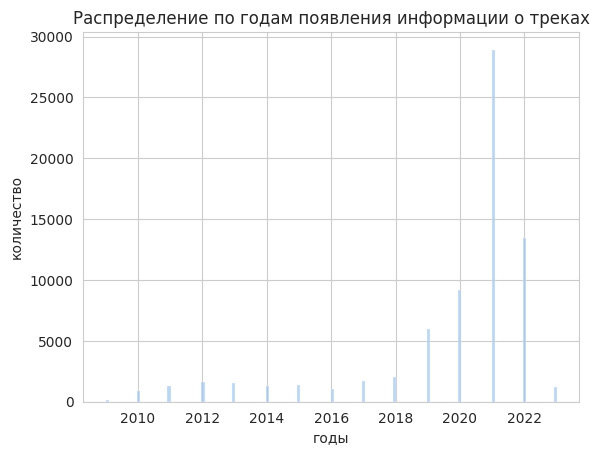

In [ ]:
sns.histplot(data.dttm.dt.year)
plt.title('Распределение по годам появления информации о треках')
plt.xlabel('годы')
plt.ylabel('количество');

Вывод: Треки были загружены на ресурс в период с 2010 по 2023 год.Большинство треков были загружены на ресурс в 2021 году. На основании даты загрузки невозможно сделать вывод о годе выхода песни.

Теперь посмотрим на распределение целевой переменной:

In [ ]:
distrib = data.track_remake_type.value_counts().to_frame(name='Итого:')
percentage_column = 'Проценты'
total_count = distrib['Итого:'].sum()
distrib = distrib.assign(**{percentage_column: lambda x: (x['Итого:'] / total_count) * 100})
print(distrib)

          Итого:   Проценты
COVER      67304  94.003939
ORIGINAL    4293   5.996061


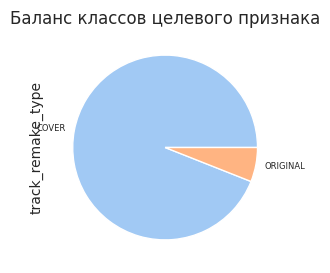

In [ ]:
data['track_remake_type'].value_counts().plot(kind='pie', figsize=(3, 3), labeldistance=1.1,
               pctdistance=0.95, fontsize=6, title='Баланс классов целевого признака')
plt.show()

**Вывод**: В датасете количество оригинальных треков составляет только 6% от всего количества

In [ ]:
data[data.track_remake_type=='COVER'].shape[0]\
    - data[data.track_remake_type=='COVER'].original_track_id.isna().sum()

528

**Вывод**: При подсчете количества треков типа 'COVER', у которых есть информация о том, какой оригинальный трек они переосмысливают имеются данные только о 528 таких записях.

In [ ]:
data.language.value_counts().to_frame(name='Итого:')

,Итого:
EN,15194
ES,1746
RU,1545
IT,907
HI,285
...,...
SE,1
LV,1
AV,1
IU,1


**Вывод**: треки исполнены на 85 языках. Примерно 20 % треков определены как написанные на английском языке. Однако в этом признаке очень много пропусков.


Посмотрим распределение данных по длительности треков:

In [ ]:
data.duration.value_counts().to_frame(name='Итого:')

,Итого:
0.0,369
28000.0,121
30000.0,86
180000.0,75
192000.0,70
...,...
405570.0,1
117440.0,1
199430.0,1
118620.0,1


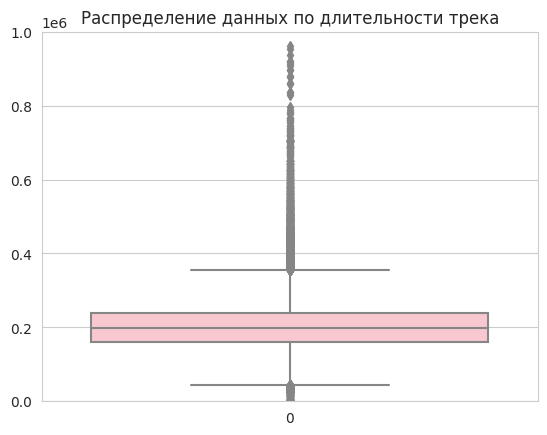

In [ ]:
sns.boxplot(data.duration, color='pink')
plt.ylim(0, 1000000)
plt.title('Распределение данных по длительности трека')
plt.show()

- мы имеем: 23581 вариацию длительности, в столбце с длительностью трека есть 369 строк со значением 0:

In [ ]:
data[data.duration==0].sample(5)

,original_track_id,track_id,track_remake_type,dttm,title,language,isrc,genres,duration
67416,None,8942994694f7ed3f47b7ec92fb55a0c1,COVER,2022-06-30,La Corrida,FR,QZK6K2279020,electronics,0.0
35374,None,ebba4b76faead2ee0d229f119864a4d1,COVER,2021-04-30,Something New,EN,USLZJ2143985,rap,0.0
38317,None,aafa801996a33e812d69923bf8171194,COVER,2021-05-31,Por Que Eu?,None,QZHZ42178498,spiritual,0.0
68544,None,6d1d44c1601f1329567386167841dd64,COVER,2022-07-31,Toss A Coin To Your Witcher,CS,QZMEM2234062,soundtrack,0.0
15980,None,4776f168e2201dfd32d6e00add694c42,COVER,2019-04-30,Societas Satanas,None,FR33T0819525,"blackmetal,metal",0.0


- кроме столбца с длительностью эти данные могут иметь полезную информацию, и поэтому пока не буду их удалять, и заменю ноли на медианные значения по категории(возможно в будущем их нужно будет удалить)

In [ ]:
data[data.duration==0].duration.replace(0.0, data.duration.median(), inplace=True)

- преобразуем столбец с длительностью трека: переведем его из милисекунд в секунды и округлим результат до двух знаков после запятой.

In [ ]:
data.duration = round(data.duration/1000, 2)

Анализ ISRC данных

In [ ]:
data['isrc'].value_counts()

FR33T0819525    3
USTCF1017794    3
USTCF1018560    3
INA981800119    2
RUB422101343    2
               ..
QZHZ62013161    1
QZHZ62013162    1
QZHZ62013163    1
QZHZ62017040    1
DGA0M2316512    1
Name: isrc, Length: 71115, dtype: int64

In [ ]:
# Подсчет количества дубликатов
duplicate_count = data.duplicated(subset=['isrc']).sum()
print(f"Количество дубликатов в столбце 'isrc': {duplicate_count}")

Количество дубликатов в столбце 'isrc': 481


Так код isrc является уникальным и определить его точное отношение к тем или иным данным пока не предоставляется возможным, уберу дубликаты по этому признаку(потери составят менее 1%)

In [ ]:
# Удаление дубликатов
data.drop_duplicates(subset=['isrc'], keep='first', inplace=True)
print(f"Количество уникальных значений в столбце 'isrc' после удаления дубликатов: {data['isrc'].nunique()}")

Количество уникальных значений в столбце 'isrc' после удаления дубликатов: 71115


In [ ]:
data['isrc'].isna().sum()

1

In [ ]:
data.dropna(subset=['isrc'], inplace=True)

In [ ]:
data.shape

(71115, 9)

In [ ]:
data['isrc'].value_counts()

USFI86900049    1
QZPJ32105057    1
QZNJW2120803    1
QZNJW2118793    1
QZNJW2120364    1
               ..
QZHZ62079479    1
QZHZ62083100    1
RUB422001752    1
QZHZ62051198    1
DGA0M2316512    1
Name: isrc, Length: 71115, dtype: int64

In [ ]:
isrc_lengths = data['isrc'].str.len()

# Подсчет уникальных значений длины строк
unique_lengths = isrc_lengths.nunique()

# Вывод результата
if unique_lengths == 1:
    print("Все значения в колонке 'isrc' имеют одинаковую длину.")
    print(f"Длина строк: {isrc_lengths.iloc[0]}")
else:
    print("Значения в колонке 'isrc' имеют разную длину.")
    print(f"Уникальные длины строк: {isrc_lengths.unique()}")

Значения в колонке 'isrc' имеют разную длину.
Уникальные длины строк: [12 15]


In [ ]:
invalid_isrc_rows = data[data['isrc'].str.len() != 12]

# Вывод результатов
print("Строки с isrc, отличным от 12 символов:")
print(invalid_isrc_rows)

Строки с isrc, отличным от 12 символов:
                     original_track_id                          track_id  \
2450  d5c1ea7f7977cb45d4a838ed81c72574  d5c1ea7f7977cb45d4a838ed81c72574   

     track_remake_type       dttm                     title language  \
2450          ORIGINAL 2014-05-31  Научиться бы не париться     None   

                 isrc genres  duration  
2450  QM-PU5-12-05766    pop    207.12  


In [ ]:
data['isrc'] = data['isrc'].str.replace('-', '')

#### Добавление признаков из кода  isrc

- так как в уникальном коде isrc данные зашифрованы следующим образом:
  - первые два символа страна регистрации трека,
  - следующие три символа - правообладатель трека(исполнитель/лейбл),
  - следующие два символа - год релиза трека,
  - последние пять символов - номер трека (его использовать в анализе не буду),

разобьем его на эти составляющие и вынесем в отдельные признаки

Я решила использовать библиотеку pandarallel, чтобы распараллелить процесс обработки данных

In [ ]:
# Инициализируем pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
# функция, которая принимает значение столбца 'isrc' и возвращает DataFrame с новыми признаками
def extract_info(row):
    isrc = row['isrc']
    return pd.Series({
        'country': isrc[:2],
        'owner': isrc[2:5],
        'realis_year': isrc[5:7]
    })

# Применяем функцию к строкам с использованием pandarallel
data[['country', 'owner', 'realis_year']] = data.parallel_apply(extract_info, axis=1)

In [ ]:
data.sample(5)

,original_track_id,track_id,track_remake_type,dttm,title,language,isrc,genres,duration,country,owner,realis_year
56514,None,39a1d9af4cff59be3e34ef76c99fbf1c,COVER,2021-12-31,Mía,None,QZTPX2166083,pop,180.16,QZ,TPX,21
1417,None,c6ab9f9b4737e341e29729d3c160a161,COVER,2017-01-31,I Don't Need No Doctor,EN,GBCQV8600034,"metal,classicmetal",206.97,GB,CQV,86
62113,None,3a18f933c5371fcd23d56f1dd6e1b821,COVER,2022-03-31,GOFUKURSELF!,EN,QZDA72289525,punk,128.66,QZ,DA7,22
10373,None,dd7d499c0c1e8f1c61c9db6b3ae588cb,COVER,2017-03-31,"If I Had a Boat (From ""Still Alice"")",EN,CB2CY0946626,soundtrack,278.17,CB,2CY,09
35204,None,97abaa6e440b76fc71c3c9b27aba7f68,COVER,2021-04-30,Usta,TR,FR59R2176451,folk,292.80,FR,59R,21


In [ ]:
data.realis_year.unique()

array(['69', '04', '07', '09', '01', '99', '70', '05', '98', '08', '68',
       '93', '90', '86', '67', '03', '94', '60', '91', '75', '02', '00',
       '06', '79', '95', '65', '80', '77', '74', '89', '84', '87', '88',
       '96', '58', '97', '66', '54', '85', '57', '81', '51', '92', '10',
       '73', '82', '12', '18', '83', '44', '76', '63', '15', '13', '11',
       '16', '14', '22', '17', '19', '20', '21', '23', '24', '25', '42',
       '26', '33', '30', '71', '64', '38', '78', '50', '36', '35', '62'],
      dtype=object)

- теперь приведем столбец с годом релиза к полному формату

In [ ]:
data['realis_year'] = pd.to_datetime(data['realis_year'], format='%y').dt.year

In [ ]:
data[['realis_year', 'track_remake_type']]

,realis_year,track_remake_type
0,1969,ORIGINAL
1,1969,ORIGINAL
2,2004,ORIGINAL
3,2007,ORIGINAL
4,2009,COVER
...,...,...
71592,2023,ORIGINAL
71593,2023,COVER
71594,2023,COVER
71595,2000,ORIGINAL


**Вывод**: Была проведена предобработка объединенного датасета, выделены новые признаки - год релиза трека, страна, лейбл, который трек зарегистрировал. Так же обработаны данные о длительности трека

## **Создание Датасета на основе текстов песен**

Для выработки качественной системы предложений необходимо использовать так же тексты песен, поэтомы приняли решение создать датасет, основывающийся на этих данных. Для того, чтобы использовать тексты в полной мере их необходимо сначала предобработать.

In [ ]:
df_text = lyrics.copy()

### Очистка текстов от символов, приведение к нижнему регистру

In [ ]:
# Функция для очистки текста от лишних символов
def clean_text(text):
    # приводим текст к нижнему регистру
    text = text.lower()
    # создаем регулярное выражение для удаления лишних символов
    regular = r'[\*+\#+\№\"\-+\+\=+\?+\&\^\.+\;\,+\>+\(\)\/+\:\\+]'
    # удаляем лишние символы
    text = re.sub(regular, '', text)
    # удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    # возвращаем очищенные данные
    return text

In [ ]:
# создаем список для хранения очищенных данных
cleaned_text = []
# для каждого текста трека из столбца text
for text in df_text['text']:
    # очищаем данные
    text = clean_text(text)
    # добавляем очищенные данные в список cleaned_text
    cleaned_text.append(text)
# записываем очищенные данные в новую колонку 'cleaned_text'
df_text['cleaned_text'] = cleaned_text

In [ ]:
df_text.head()

,text,track_id,cleaned_text
0,"Живу сейчас обломами, обломками не той любви\n...",1c4b1230f937e4c548ff732523214dcd,живу сейчас обломами обломками не той любви по...
1,Tell me your fable\nA fable\nTell me your fabl...,0faea89b0d7d6235b5b74def72511bd8,tell me your fable a fable tell me your fable ...
2,You're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741,you're ashamed about all your fears and doubts...
3,You're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1,you're ashamed about all your fears and doubts...
4,"You showed him all the best of you,\nBut I'm a...",8d70930d09cd239c948408d1317d8659,you showed him all the best of you but i'm afr...


In [ ]:
df_text.duplicated().sum()

0

In [ ]:
df_text['track_id'].value_counts()

adc126c946551da4e1784e716b77992e    10
f0f429d03fdd19f08ff60e889e32aae2     8
f5da21fe563623eab22581b287412a97     8
8a43257f07dd1fcfa6cfb92d0b7cb703     7
86afaff232b86d6ae5d6c9a1f967549f     7
                                    ..
e44404ec63a98c94f176e2c52fee5a06     1
e4b1d2b68d16307d9b58a59510309a65     1
c089f8d42dd6815e3be20869a1f98a93     1
a8d791db22ff2a9267ce5f24cbfe145a     1
c860754a50dac664d847bca85e6897f4     1
Name: track_id, Length: 10277, dtype: int64

Я предполагаю, что можно сравнить тексты среди одинаковых track_id и оставить только самый длинный текст, а остальные удалить. Колонку с исходными текстами сразу удалю.

In [ ]:
def filter_longest_text(df):
    # Создаем словарь для отслеживания самого длинного текста по каждому track_id
    longest_text_dict = {}

    for i, row in df.iterrows():
        track_id = row['track_id']
        text = row['cleaned_text']

        # Проверяем, существует ли запись для данного track_id в словаре
        if track_id in longest_text_dict:
            # Сравниваем длину текущего текста с длиной текста, сохраненного в словаре
            if len(text) > len(longest_text_dict[track_id]):
                # Если текущий текст длиннее, обновляем его в словаре
                longest_text_dict[track_id] = text
        else:
            # Если записи для данного track_id еще нет, добавляем его в словарь
            longest_text_dict[track_id] = text

    # Создаем новый DataFrame только с самыми длинными текстами
    longest_texts = pd.DataFrame(longest_text_dict.items(), columns=['track_id', 'cleaned_text'])

    return longest_texts

In [ ]:
df_text = filter_longest_text(df_text)

In [ ]:
df_text.shape

(10277, 2)

In [ ]:
df_text['track_id'].value_counts()

1c4b1230f937e4c548ff732523214dcd    1
03ea92aabaa550ba410aa654718b0fea    1
a6153a12c9d6b2d8fd6bedfde7e4debd    1
c00194bc65c630f9b22adb30b2975a22    1
b1c74c7601e3217135e513d1fe2310e7    1
                                   ..
7b6ab973140fe54a1dc409ba3d977fff    1
d5749c71101e7e66c5eb5d1802e120e8    1
9b63b54a039cb3320a53c6285e58764c    1
2f970eaa3ff6eb9cae9fe81fb500706c    1
c860754a50dac664d847bca85e6897f4    1
Name: track_id, Length: 10277, dtype: int64

In [ ]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10277 entries, 0 to 10276
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   track_id      10277 non-null  object
 1   cleaned_text  10277 non-null  object
dtypes: object(2)
memory usage: 160.7+ KB


**Вывод**: Была проведена предобработка текстов треков, тексты очищены от лишних символов и пробелов, из треков с одинаковым id оставлен только самый длинный

###**Кодирование текстов песен**

Решила закодировать тексты песен в эмбеддинги, для того, чтобы найти каверы на других языках. Для кодирования использую модель LaBSE из sentence-transformers с huggingface. Эту модель можно использовать для отображения 109 языков в общее векторное пространство.
Создам модель и функцию для кодирования

In [ ]:
model = SentenceTransformer('sentence-transformers/LaBSE')

Создам тестовый датасет из 50 треков для того, чтобы проверить работу модели

In [ ]:
df_sample = df_text.sample(n=50, random_state=42)
df_sample.shape

(50, 2)

In [ ]:
%%time
df_sample['embeddings'] = df_sample['cleaned_text'].apply(lambda x: model.encode(x))

CPU times: user 2.48 s, sys: 291 ms, total: 2.77 s
Wall time: 2.78 s


In [ ]:
df_sample.head()

,track_id,cleaned_text,embeddings
5601,608d455455c1a6c3cbaeca5898777b25,ohh i i just died in your arms tonight it must...,"[-0.03870982, -0.056471504, -0.03429442, -0.07..."
2108,59d96a7a8307a19682dd1f0f1167e009,i'm about to lose my mind you've been gone for...,"[0.014847649, -0.020382717, 0.028208174, -0.08..."
2516,9da2b1dbb63563cfae3ec10b08516003,every night in my dreams i see you i feel you ...,"[-0.04810754, -0.039957583, -0.015507625, -0.0..."
7318,d214dfa84fb4f71dd9ce80ef1cf8a18a,have you got color in your cheeks' do you ever...,"[-0.0363334, -0.026963715, 0.00525739, -0.0691..."
33,d6317726d92075f66fd7e714fdb95ab4,now that i've lost everything to you you say y...,"[-0.04006581, -0.04991986, 0.021831702, -0.071..."


Проверим размерность полученных векторов

In [ ]:
    # Извлекаем векторы из колонки
embeddings = df_sample['embeddings'].tolist()

    # Проверяем размерность всех векторов
vector_dimensions = [len(embedding) for embedding in embeddings]

    # Подсчитываем уникальные значения размерности
unique_dimensions = pd.Series(vector_dimensions).nunique()

    # Выводим результаты
    if unique_dimensions == 1:
        print(f"Все векторы в колонке embeddings имеют одинаковую размерность.")
        print(f"Размерность векторов: {vector_dimensions[0]}")
    else:
        print(f"Векторы в колонке embeddings имеют разную размерность.")
        print(f"Уникальные размерности векторов: {vector_dimensions}")

Все векторы в колонке embeddings имеют одинаковую размерность.
Размерность векторов: 768


Для удобства работы можно применить методы понижения размерности к полученным эмбеддингам для уменьшения числа признаков. Одним из часто используемых методов является метод главных компонент (Principal Component Analysis, PCA). PCA позволяет проецировать данные на пространство меньшей размерности, сохраняя при этом максимальную дисперсию данных. Сначала определю до какой размерности опуститься, не потеряв дисперсию

In [ ]:
# Извлекаем векторы из колонки 'embeddings'
sentence_embeddings = np.array(embeddings)

# Создаем объект PCA
n_components = min(sentence_embeddings.shape[0], sentence_embeddings.shape[1]) - 1
pca = PCA(n_components=n_components)  # Установите начальное количество компонент равным размерности векторов

# Применяем PCA к эмбеддингам
pca.fit(sentence_embeddings)

# Вычисляем объясненную дисперсию для каждой компоненты
explained_variance_ratio = pca.explained_variance_ratio_

# Вычисляем накопленную объясненную дисперсию
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Определяем количество компонент, чтобы сохранить, например, 95% объясненной дисперсии
desired_variance_ratio = 0.98
n_components = np.argmax(cumulative_explained_variance >= desired_variance_ratio) + 1

# Повторно применяем PCA с выбранным количеством компонент
pca = PCA(n_components=n_components)
embedded_data_pca = pca.fit_transform(sentence_embeddings)

# Выводим результаты
print("Исходная размерность данных:", sentence_embeddings.shape[1])
print("Новая размерность данных после PCA:", n_components)


Исходная размерность данных: 768
Новая размерность данных после PCA: 45


Приняла решение в дальнейшем снизить размерность векторов до 150

После тестирования функции можно применить ее ко всему датасету с текстами песен

In [ ]:
%%time
df_text['embeddings'] = df_text['cleaned_text'].apply(lambda x: model.encode(x))

CPU times: user 3min 6s, sys: 603 ms, total: 3min 7s
Wall time: 3min 9s


И снизить размерность эмбеддингов до 150

In [ ]:
embedding_column = 'embeddings'

# Извлекаем векторы из указанной колонки и преобразуем в массив NumPy
sentence_embeddings = np.array(df_text[embedding_column].tolist())

# Задайте количество компонент (целевую размерность)
n_components = 150  # Задайте желаемую размерность

# Создайте объект PCA
pca = PCA(n_components=n_components)

# Примените PCA к эмбеддингам
embedded_data_pca = pca.fit_transform(sentence_embeddings)

# Замените содержимое колонки 'embeddings' на уменьшенные векторы
df_text[embedding_column] = embedded_data_pca.tolist()

# Выведите результаты
print("Размерность исходных данных:", sentence_embeddings.shape)
print("Размерность данных после PCA:", embedded_data_pca.shape)
print("Обновленный DataFrame:")
print(df_text.head(2))

Размерность исходных данных: (10277, 768)
Размерность данных после PCA: (10277, 150)
Обновленный DataFrame:
                           track_id  \
0  1c4b1230f937e4c548ff732523214dcd   
1  0faea89b0d7d6235b5b74def72511bd8   

                                        cleaned_text  \
0  живу сейчас обломами обломками не той любви по...   
1  tell me your fable a fable tell me your fable ...   

                                          embeddings  
0  [0.21405859291553497, 0.0503949299454689, 0.01...  
1  [-0.0034704282879829407, 0.07193426042795181, ...  


In [ ]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10277 entries, 0 to 10276
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   track_id      10277 non-null  object
 1   cleaned_text  10277 non-null  object
 2   embeddings    10277 non-null  object
dtypes: object(3)
memory usage: 241.0+ KB


### Объединени датасетов data и тексты

In [ ]:
df_text1 = df_text.merge(data, on='track_id')
df_text1.shape

(9974, 14)

In [ ]:
df_text1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9973
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   track_id           9974 non-null   object        
 1   cleaned_text       9974 non-null   object        
 2   embeddings         9974 non-null   object        
 3   original_track_id  2992 non-null   object        
 4   track_remake_type  9974 non-null   object        
 5   dttm               9974 non-null   datetime64[ns]
 6   title              9974 non-null   object        
 7   language           6222 non-null   object        
 8   isrc               9974 non-null   object        
 9   genres             9974 non-null   object        
 10  duration           9974 non-null   float64       
 11  country            9974 non-null   object        
 12  owner              9974 non-null   object        
 13  realis_year        9974 non-null   int64         
dtypes: datet

Объединение решили произвести по совпадению данных. К сожалению о некоторых треках с текстами в датасете data информации нет, поэтому рабочий датасет содержит 9974 строки. Пропуски присутствуют только в колонках язык и original_track_id

In [ ]:
df_text = df_text1.copy()

### Обработка названий треков

Для работы с названиями треков нужно привести их нижнему регистру и очистить от знаков препинания

In [ ]:
# создаем список для хранения очищенных данных
cleaned_title = []
# для каждого назвавния трека из столбца title
for text in df_text['title']:
    # очищаем данные
    text = clean_text(text)
    # добавляем очищенные данные в список cleaned_title
    cleaned_title.append(text)
# записываем очищенные данные в новую колонку 'cleaned_title'
df_text['cleaned_title'] = cleaned_title

In [ ]:
df_text.head()

,track_id,cleaned_text,embeddings,original_track_id,track_remake_type,dttm,title,language,isrc,genres,duration,country,owner,realis_year,cleaned_title
0,1c4b1230f937e4c548ff732523214dcd,живу сейчас обломами обломками не той любви по...,"[0.21405859291553497, 0.0503949299454689, 0.01...",1c4b1230f937e4c548ff732523214dcd,ORIGINAL,2018-09-30,Сарафан,None,AEA0D1860569,bard,140.00,AE,A0D,2018,сарафан
1,0faea89b0d7d6235b5b74def72511bd8,tell me your fable a fable tell me your fable ...,"[-0.0034704282879829407, 0.07193426042795181, ...",None,COVER,2021-08-31,Children,None,QZS672199805,electronics,214.59,QZ,S67,2021,children
2,9c6dc41d5ccd9968d07f055da5d8f741,you're ashamed about all your fears and doubts...,"[-0.044518373906612396, -0.22035308182239532, ...",9c6dc41d5ccd9968d07f055da5d8f741,ORIGINAL,2010-05-31,Briane,None,USUM71006645,rock,317.91,US,UM7,2010,briane
3,bfd04a73e9cffdf0e282c92219a86ea1,you're ashamed about all your fears and doubts...,"[-0.04451827332377434, -0.22035405039787292, -...",bfd04a73e9cffdf0e282c92219a86ea1,ORIGINAL,2014-09-30,Briane,None,USM951100211,rock,317.86,US,M95,2011,briane
4,8d70930d09cd239c948408d1317d8659,you showed him all the best of you but i'm afr...,"[-0.07507092505693436, -0.18179209530353546, -...",8d70930d09cd239c948408d1317d8659,ORIGINAL,2010-05-31,Broken Angel,None,USUM71006638,rock,321.28,US,UM7,2010,broken angel


In [ ]:
df_text.isna().sum()

track_id                0
cleaned_text            0
embeddings              0
original_track_id    6982
track_remake_type       0
dttm                    0
title                   0
language             3752
isrc                    0
genres                  0
duration                0
country                 0
owner                   0
realis_year             0
cleaned_title           0
dtype: int64

In [ ]:
df_text.groupby(['cleaned_title'])['cleaned_text'].count().sort_values()

cleaned_title
1 0 0 1 1                                          1
the fever                                          1
the evil within 2 ordinary world trailer music     1
the end of evangelion komm süsser tod piano        1
the district sleeps alone tonight                  1
                                                  ..
smooth criminal                                   19
smells like teen spirit                           21
stand by me                                       22
toxic                                             27
wicked game                                       38
Name: cleaned_text, Length: 7488, dtype: int64

Возьму для примера 3 трека, имеющие нескольно вариантов текста - wicked game, toxic и temporary с одним вариантом  

In [ ]:
sample = df_text.loc[(df_text['cleaned_title'] == 'wicked game') |
                     (df_text['cleaned_title'] == 'toxic') |
                     (df_text['cleaned_title'] =='temporary')
                     ]
sample.head()

,track_id,cleaned_text,embeddings,original_track_id,track_remake_type,dttm,title,language,isrc,genres,duration,country,owner,realis_year,cleaned_title
198,245ab5617e7621d6b5bc7c9a2cd47271,thoughts spin hard to breathe we are temporary...,"[0.244267538189888, 0.25890660285949707, 0.054...",245ab5617e7621d6b5bc7c9a2cd47271,ORIGINAL,2021-04-30,Temporary,EN,QZFYY2194572,electronics,124.81,QZ,FYY,2021,temporary
310,6c56a114f6f1608c666cd67cd86042de,no one like no one like i never thought i'd be...,"[0.10317667573690414, -0.19954201579093933, 0....",f3e5e9db509f9b6f6d93b9c38e4e1324,COVER,2019-06-30,Wicked Game,None,TCADW1839732,rnb,156.29,TC,ADW,2018,wicked game
415,755f08335f8436fafd3806fe9c5b867a,the world was on fire and no one could save me...,"[-0.014525964856147766, -0.1434280276298523, 0...",f3e5e9db509f9b6f6d93b9c38e4e1324,COVER,2021-01-31,Wicked Game,EN,GBKPL1668098,alternative,284.80,GB,KPL,2016,wicked game
620,9fb19ba70fc34f143c734d5dd8ac8e26,baby can't you see i'm calling a girl like you...,"[-0.25127318501472473, -0.08757111430168152, 0...",53a04991308c2cc9179fdd401fea83a3,COVER,2018-12-31,Toxic,EN,GBKPL1776594,pop,174.22,GB,KPL,2017,toxic
876,abf209547f77844456526934076358f2,the world was on fire and no one could save me...,"[-0.024191133677959442, -0.17983496189117432, ...",f3e5e9db509f9b6f6d93b9c38e4e1324,COVER,2017-02-28,Wicked Game,EN,DEN061600356,electronics,215.20,DE,N06,2016,wicked game


In [ ]:
sample.groupby(['cleaned_title', 'track_remake_type', 'language', 'realis_year'])['title'].count()

cleaned_title  track_remake_type  language  realis_year
temporary      ORIGINAL           EN        2021           1
toxic          COVER              EN        2006           1
                                            2007           2
                                            2008           2
                                            2009           1
                                            2010           1
                                            2012           1
                                            2014           1
                                            2015           1
                                            2016           1
                                            2017           5
                                            2018           2
                                            2020           1
                                            2021           1
               ORIGINAL           EN        2021           1
wicked game    COVER         

- У трека wicked game отмечен 1 оригинал с датой релиза 2006 год, при этом самый ранний трек из каверов датирован 1997 годом.
- У трека toxic оригиналом отмечен трек с релизом в 2021 году, каверы все имеют более ранний год релиза


Есть сомнения, что в датасете корректно размечены оригиналы и каверы. Возможно следует предположить, что оригиналом должен быть самый ранний трек(если оригинал вообще присутствует в выборке). Следует создать признак - самый ранний трек

### Обработка пропусков в языке

Приведу все значения метки языка к нижнему регистру, чтобы избежать дублей

In [ ]:
df_text['language'] = df_text['language'].str.lower()

In [ ]:
df_text['language'].unique()

array([None, 'es', 'en', 'pt', 'ru', 'uk', 'it', 'ja', 'da', 'fr', 'sw',
       'de', 'no', 'ro', 'ms', 'hi', 'th', 'as', 'id', 'ar', 'tr', 'sr',
       'vi', 'ia', 'et', 'pa', 'tl', 'pl', 'sv', 'ta', 'hu', 'ml', 'af',
       'el', 'he', 'az', 'ha', 'si', 'kn', 'sk', 'ie', 'zh', 'la', 'sq',
       'nl', 'te', 'uz'], dtype=object)

Необходимо заполнить пропуски в языке исполнения. Воспользуюсь для этого библиотекой langtest, которая умеет определять 55 языков.

In [ ]:
def fill_language_column(df):
    for index, row in df.iterrows():
        text = row['cleaned_text']
        language = row['language']

        if pd.isna(language):  # Проверяем, есть ли пропуск в колонке 'language'
            try:
                detected_language = detect(text)
                df.at[index, 'language'] = detected_language
            except:
                df.at[index, 'language'] = 'unknown'  # Если не удалось определить язык, можно использовать 'unknown', как значение по умолчанию
    return df

In [ ]:
%%time
df_text = fill_language_column(df_text)

CPU times: user 32.7 s, sys: 193 ms, total: 32.9 s
Wall time: 33.1 s


In [ ]:
df_text.loc[df_text['language'] == 'unknown'].value_counts().sum()

0

In [ ]:
df_text['language'].unique()

array(['ru', 'en', 'es', 'pt', 'uk', 'fr', 'it', 'ja', 'cy', 'cs', 'da',
       'pa', 'sw', 'de', 'no', 'ro', 'ca', 'hi', 'ms', 'hr', 'bg', 'th',
       'pl', 'as', 'so', 'tl', 'sq', 'id', 'ar', 'tr', 'sr', 'vi', 'af',
       'sv', 'ia', 'bn', 'et', 'ta', 'hu', 'ml', 'el', 'fi', 'he', 'az',
       'ha', 'si', 'kn', 'sk', 'ie', 'ko', 'te', 'zh', 'zh-cn', 'la',
       'nl', 'uz'], dtype=object)

In [ ]:
df_text['language'].nunique()

56

***Выводы по процессу обработки имеющихся признаков и созданию новых:***
- нами была проведена обработка всех имеющихся текстовых признаков:
  - приведение к единому регистру, удаление "шумных данных"
  - разделение списка с жанрами треков на составляющие, "очистка" и приведение к общему виду
  - удаление дубликатов в текстах
  - восстановление пропусков в признаке с языком исполнения при помощи библиотеки langtest
- создание новых признаков из уникального isrc кода(страна релиза, год релиза, правообладатель трека, серийный номер)

### Анализ полученного датасета, основанного на текстах

In [ ]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9973
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   track_id           9974 non-null   object        
 1   cleaned_text       9974 non-null   object        
 2   embeddings         9974 non-null   object        
 3   original_track_id  2992 non-null   object        
 4   track_remake_type  9974 non-null   object        
 5   dttm               9974 non-null   datetime64[ns]
 6   title              9974 non-null   object        
 7   language           9974 non-null   object        
 8   isrc               9974 non-null   object        
 9   genres             9974 non-null   object        
 10  duration           9974 non-null   float64       
 11  country            9974 non-null   object        
 12  owner              9974 non-null   object        
 13  realis_year        9974 non-null   int64         
 14  cleaned_

In [ ]:
df_text.isna().sum()

track_id                0
cleaned_text            0
embeddings              0
original_track_id    6982
track_remake_type       0
dttm                    0
title                   0
language                0
isrc                    0
genres                  0
duration                0
country                 0
owner                   0
realis_year             0
cleaned_title           0
dtype: int64

In [ ]:
df_text.groupby(['track_remake_type'])['original_track_id'].count()

track_remake_type
COVER        324
ORIGINAL    2668
Name: original_track_id, dtype: int64

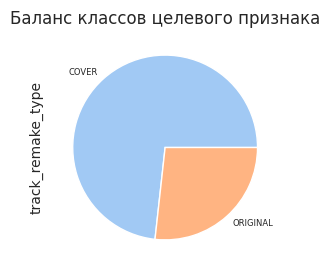

In [ ]:
df_text['track_remake_type'].value_counts().plot(kind='pie', figsize=(3, 3), labeldistance=1.1,
               pctdistance=0.95, fontsize=6, title='Баланс классов целевого признака')
plt.show()

In [ ]:
df_text.columns

Index(['track_id', 'cleaned_text', 'embeddings', 'original_track_id',
       'track_remake_type', 'dttm', 'title', 'language', 'isrc', 'genres',
       'duration', 'country', 'owner', 'realis_year', 'cleaned_title'],
      dtype='object')

Удалю колонки, которые не буду использовать для обучения. Название - оставлю обработанное

In [ ]:
df_text.drop(['title', 'dttm'], axis=1, inplace=True)
df_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9973
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           9974 non-null   object 
 1   cleaned_text       9974 non-null   object 
 2   embeddings         9974 non-null   object 
 3   original_track_id  2992 non-null   object 
 4   track_remake_type  9974 non-null   object 
 5   language           9974 non-null   object 
 6   isrc               9974 non-null   object 
 7   genres             9974 non-null   object 
 8   duration           9974 non-null   float64
 9   country            9974 non-null   object 
 10  owner              9974 non-null   object 
 11  realis_year        9974 non-null   int64  
 12  cleaned_title      9974 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 1.3+ MB


**Выводы:**
- сделан вывод о наличии дисбаланса классов целевой переменной в сторону нулевого класса(класс отсутствия оригинального трека)

## Группировка

Для того, чтобы сделать группировку, я буду использовать метод сравнения косинусного растояния.
Нужно сопоставить косинусное расстояние между track_id кавера и соответствующего ему оригинала, трек id которого, указан в колонке original_track_id. В колонке original_track_id очень много пропусков, но нужно сравнить имеющиеся данные, чтобы оценить расстояния для всех известных пар трек-оригинал и написать удобную функцию и оценить в каком диапазоне расстояний модель ошибается.



In [ ]:
# 1. Выбираем только те строки, где 'original_track_id' не пропущен
df_with_originals = df_text.dropna(subset=['original_track_id'])

# 2. Вычисляем эмбеддинги для каверов и соответствующих им оригиналов
cover_embeddings = np.array(df_with_originals[df_with_originals['track_remake_type'] == 'COVER']['embeddings'].tolist())
original_embeddings = np.array(df_with_originals[df_with_originals['track_remake_type'] == 'ORIGINAL']['embeddings'].tolist())

# 3. Рассчитываем косинусное расстояние между эмбеддингами
cosine_distances = 1 - cosine_similarity(normalize(cover_embeddings), normalize(original_embeddings))

# 4. Создаем DataFrame с косинусными расстояниями и соответствующими track_id и текстами
distances_df = pd.DataFrame({
    'cover_track_id': df_with_originals[df_with_originals['track_remake_type'] == 'COVER']['track_id'].values,
    'original_track_id': df_with_originals[df_with_originals['track_remake_type'] == 'COVER']['original_track_id'].values,
    'cosine_distance': np.diag(cosine_distances)
})

# 5. Добавляем тексты
distances_df = distances_df.merge(
    df_with_originals[['track_id', 'cleaned_text']].rename(columns={'cleaned_text': 'cover_text'}),
    left_on='cover_track_id',
    right_on='track_id',
    how='left'
)
distances_df = distances_df.merge(
    df_with_originals[['track_id', 'cleaned_text']].rename(columns={'cleaned_text': 'original_text'}),
    left_on='original_track_id',
    right_on='track_id',
    how='left'
)

# 6. Удаляем лишние столбцы
distances_df = distances_df[['cover_track_id', 'original_track_id', 'cosine_distance', 'cover_text', 'original_text']]

# 7. Выводим результаты
print(distances_df)


                       cover_track_id                 original_track_id  \
0    0de3fe3c1a9417977533689397ed6a29  b1ad56e98ad6d380134498a4c5ca907e   
1    59fbc1e7e005843d19242659bdde0c2b  1e8ca836c962598551882e689265c1c5   
2    e58d2c71ff16648513a9c727281fb474  eeb69a3cb92300456b6a5f4162093851   
3    41e0775c05a394e25575d5cc9f104ab6  0fcb82fec458a0993f848200548eaaa0   
4    29537139dc0d2f9ec26692835caf7809  7b6ab973140fe54a1dc409ba3d977fff   
..                                ...                               ...   
319  c2fd70052a8733d7a0ae831f1019b8cc  f3e5e9db509f9b6f6d93b9c38e4e1324   
320  3bfa501df5d5e114ede47e5d377916f9  5a1fce1ebb19da07487f3132b261b78e   
321  928822b7f0e3ff908a18afd149997df5  2088e90e1ba4e0600c38a55baee709a6   
322  99f2e01db6dcffbc31fc35e5c8b2ba1d  cfcd208495d565ef66e7dff9f98764da   
323  e5b3468f9f56adb8f0d08d99b151b8aa  ad1b9fe17c16ab73b2a52920fdb1a220   

     cosine_distance                                         cover_text  \
0           1.023260  i'

### Распределение расстояний

После анализа получившегося датасета можно выделить порог 0.7 для отнесения текстов к одному треку

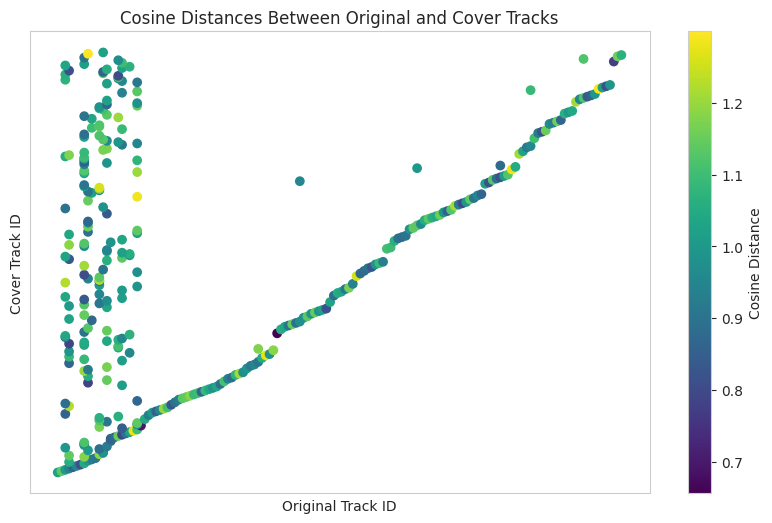

In [ ]:
# Создаем scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(distances_df['original_track_id'], distances_df['cover_track_id'], c=distances_df['cosine_distance'], cmap='viridis')

# Настраиваем оси и добавляем цветовую шкалу
plt.colorbar(label='Cosine Distance')
plt.xlabel('Original Track ID')
plt.ylabel('Cover Track ID')
plt.xticks([])
plt.yticks([])
plt.title('Cosine Distances Between Original and Cover Tracks')

# Отображаем график
plt.show()

###Группировка датасета по эмбеддингам

Я предполагаю, что треки из пары оригинал-кавер имеют одинаковое название, поэтому для ускорения процесса обработки предварительно сгруппирую треки по наименованию

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def compare_and_group_embeddings(df, embedding_column, similarity_threshold=0.7):
    # Создаем словарь, чтобы отображать каждый текст в его группу
    embedding_to_group = {}
    group_counter = 1  # Инициализируем счетчик групп

    for group_name, group_df in df.groupby(df.index):
        for i, row in group_df.iterrows():
            embedding1 = row[embedding_column]
            # Преобразуем список в строку
            embedding1_str = ",".join(map(str, embedding1))

            # Если эмбеддинг уже присвоен группе, пропускаем его
            if embedding1_str in embedding_to_group:
                continue

            # Создаем новую группу для текущего эмбеддинга
            embedding_to_group[embedding1_str] = group_counter
            group_counter += 1

            # Сравниваем текущий эмбеддинг со всеми остальными эмбеддингами внутри текущей группы
            for j, row2 in group_df.iterrows():
                embedding2 = row2[embedding_column]
                # Преобразуем список в строку
                embedding2_str = ",".join(map(str, embedding2))

                if embedding2_str in embedding_to_group:
                    continue
                # Вычисляем косинусное расстояние между эмбеддингами
                similarity = cosine_similarity([embedding1], [embedding2])[0][0]

                # Если схожесть больше заданного порога, присваиваем им одну и ту же группу
                if similarity >= similarity_threshold:
                    embedding_to_group[embedding2_str] = embedding_to_group[embedding1_str]

    # Создаем новую колонку 'cluster' с номерами групп
    df['cluster'] = [embedding_to_group[",".join(map(str, row[embedding_column]))] for i, row in df.iterrows()]

    return df


In [ ]:
%%time
grouped_all_text_df = compare_and_group_embeddings(
    df_text,
    embedding_column='embeddings',
    similarity_threshold=0.7
    )

CPU times: user 9.18 s, sys: 251 ms, total: 9.43 s
Wall time: 9.31 s


In [ ]:
grouped_all_text_df.groupby(['cleaned_title', 'cluster'])['cleaned_title'].count().sort_values()

cleaned_title           cluster
1 0 0 1 1               1129       1
take you away           6050       1
take you dancing        2863       1
                        4766       1
take you there 2008     439        1
                                  ..
mr saxobeat             3330       5
addicted to you         9503       5
balada boa              9507       6
hasta que salga el sol  9519       6
danza kuduro            9513       6
Name: cleaned_title, Length: 9734, dtype: int64

In [ ]:
grouped_all_text_df['cluster'].max()

9708

In [ ]:
# Группируем данные по номеру группы и году, подсчитываем количество
grouped = grouped_all_text_df.groupby(['cluster', 'realis_year']).size().reset_index(name='Count')

single_year_groups = (grouped.groupby('cluster')['Count'].count() == 1).sum()

print("Количество групп с одним треком:", single_year_groups)

multi_year_groups = (grouped.groupby('cluster')['Count'].count() > 1).sum()

print("Количество групп с несколькими треками:", multi_year_groups)

Количество групп с одним треком: 9579
Количество групп с несколькими треками: 129


In [ ]:
grouped_all_text_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9973
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           9974 non-null   object 
 1   cleaned_text       9974 non-null   object 
 2   embeddings         9974 non-null   object 
 3   original_track_id  2992 non-null   object 
 4   track_remake_type  9974 non-null   object 
 5   language           9974 non-null   object 
 6   isrc               9974 non-null   object 
 7   genres             9974 non-null   object 
 8   duration           9974 non-null   float64
 9   country            9974 non-null   object 
 10  owner              9974 non-null   object 
 11  realis_year        9974 non-null   int64  
 12  cleaned_title      9974 non-null   object 
 13  cluster            9974 non-null   int64  
dtypes: float64(1), int64(2), object(11)
memory usage: 1.4+ MB


In [ ]:
grouped_all_text_df['realis_year'] = grouped_all_text_df['realis_year'].astype('int')

По итогам группировки треков по тексту мы объединили 9974 треков в 9708 групп. Из них групп, куда попало несколько треков - 129

## Использование Catboost на сгруппированных данных

Подготовим модель для определения того, является ли трек оригиналом или кавером.

Для машинного обучения решили использовать модель Catboost, так как она умеет работать с эмбеддингами без предварительного кодирования.


В качестве метрики выбрали была выбрана метрика ROC AUC - так как она дает более информативную оценку качества модели при имеющемся дисбалансе классов.

In [ ]:
data_cat = grouped_all_text_df.copy()
data_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9973
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           9974 non-null   object 
 1   cleaned_text       9974 non-null   object 
 2   embeddings         9974 non-null   object 
 3   original_track_id  2992 non-null   object 
 4   track_remake_type  9974 non-null   object 
 5   language           9974 non-null   object 
 6   isrc               9974 non-null   object 
 7   genres             9974 non-null   object 
 8   duration           9974 non-null   float64
 9   country            9974 non-null   object 
 10  owner              9974 non-null   object 
 11  realis_year        9974 non-null   int64  
 12  cleaned_title      9974 non-null   object 
 13  cluster            9974 non-null   int64  
dtypes: float64(1), int64(2), object(11)
memory usage: 1.4+ MB


In [ ]:
data_cat = data_cat.drop(['track_id', 'isrc', 'cleaned_text', 'original_track_id'], axis=1)

Решила закодировать целевую колонку на 0 и 1, где 0 - это кавер, а 1 - оригинальный трек

In [ ]:
data_cat['track_remake_type'] = data_cat['track_remake_type'].replace(['COVER', 'ORIGINAL'], [0,1])

In [ ]:
target = data_cat['track_remake_type']
features = data_cat.drop('track_remake_type', axis=1)

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345, stratify=target)
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(7979, 9) (1995, 9) (7979,) (1995,)


In [ ]:
features.columns

Index(['embeddings', 'language', 'genres', 'duration', 'country', 'owner',
       'realis_year', 'cleaned_title', 'cluster'],
      dtype='object')

In [ ]:
embedding_features = ['embeddings']
text_features = ['cleaned_title']
cat_cols = ['genres', 'country', 'owner', 'language']
features_train[cat_cols] = features_train[cat_cols].astype('category')

Выделяем валидационный сет

In [ ]:
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(7979, 9) (1995, 9) (7979,) (1995,)


In [ ]:
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.2, random_state=12345, stratify=target_train)
print(features_train.shape, features_valid.shape, target_train.shape, target_valid.shape)

(6383, 9) (1596, 9) (6383,) (1596,)


In [ ]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6383 entries, 7625 to 8532
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   embeddings     6383 non-null   object  
 1   language       6383 non-null   category
 2   genres         6383 non-null   category
 3   duration       6383 non-null   float64 
 4   country        6383 non-null   category
 5   owner          6383 non-null   category
 6   realis_year    6383 non-null   int64   
 7   cleaned_title  6383 non-null   object  
 8   cluster        6383 non-null   int64   
dtypes: category(4), float64(1), int64(2), object(2)
memory usage: 388.0+ KB


In [ ]:
%%time

cat = CatBoostClassifier(
    random_state=12345,
    eval_metric='F1',
    iterations=1000,
    embedding_features=embedding_features,
    text_features = text_features,
    cat_features=cat_cols,
    verbose=50)

cat.fit(features_train, target_train, eval_set=(features_valid, target_valid))

print(f'Наилучший резйльтат: {cat.best_score_}')

Learning rate set to 0.05009
0:	learn: 0.7339028	test: 0.7265522	best: 0.7265522 (0)	total: 204ms	remaining: 3m 23s
50:	learn: 0.7748279	test: 0.7821522	best: 0.7837484 (48)	total: 5.89s	remaining: 1m 49s
100:	learn: 0.7878199	test: 0.7911803	best: 0.7922078 (83)	total: 10.4s	remaining: 1m 32s
150:	learn: 0.7931701	test: 0.8015464	best: 0.8015464 (148)	total: 16.2s	remaining: 1m 31s
200:	learn: 0.8059987	test: 0.8136882	best: 0.8136882 (197)	total: 20.8s	remaining: 1m 22s
250:	learn: 0.8136882	test: 0.8211587	best: 0.8226415 (244)	total: 25.5s	remaining: 1m 15s
300:	learn: 0.8216761	test: 0.8165829	best: 0.8226415 (244)	total: 33.4s	remaining: 1m 17s
350:	learn: 0.8265242	test: 0.8200000	best: 0.8226415 (244)	total: 43.4s	remaining: 1m 20s
400:	learn: 0.8312912	test: 0.8229426	best: 0.8229426 (399)	total: 50.5s	remaining: 1m 15s
450:	learn: 0.8371947	test: 0.8271605	best: 0.8286067 (445)	total: 56.2s	remaining: 1m 8s
500:	learn: 0.8393750	test: 0.8286067	best: 0.8320988 (467)	total: 1m

In [ ]:
predictions_train = cat.predict(features_valid)
probabilities_train = cat.predict_proba(features_valid)[:, 1]

# Вычисление метрик
roc_auc = roc_auc_score(target_valid, probabilities_train)
accuracy = accuracy_score(target_valid, predictions_train)
f1 = f1_score(target_valid, predictions_train)

In [ ]:
print('Метрика AUC ROC для модели на валидационных данных:', roc_auc)
print('Метрика Accuracy для модели на валидационных данных:', accuracy)
print('Метрика f1 для модели на валидационных данных:', f1)

Метрика AUC ROC для модели на валидационных данных: 0.9561325659153423
Метрика Accuracy для модели на валидационных данных: 0.9172932330827067
Метрика f1 для модели на валидационных данных: 0.837037037037037


In [ ]:
cm_train = confusion_matrix(target_valid, predictions_train)

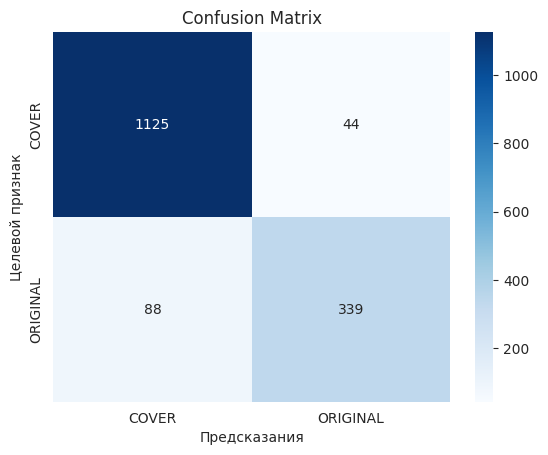

In [ ]:
ax= plt.subplot()
sns.heatmap(cm_train, annot=True, cmap='Blues', fmt='g', ax=ax)

ax.set_xlabel('Предсказания')
ax.set_ylabel('Целевой признак')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(['COVER', 'ORIGINAL'])
ax.yaxis.set_ticklabels(['COVER', 'ORIGINAL'])
plt.show()

Если внимательнее посмотреть на оценку качества модели, то обращает на себя внимание невысокая метрика recall класса "ORIGINAL".
Определение оригинального трека в данной задаче представляется более важным, поскольку существенно облегчает определение каверов (т.к. оригинальным может быть только 1 трек).
Для более адекватной оценки модели необходимо подобрать порог, при котором качество определения класса "ORIGINAL" будет не ниже класса "COVER".

In [ ]:
# Получение вероятностей для тренировочных данных
train_probs = cat.predict_proba(features_valid)[:, 1]

# Вычисление precision-recall curve
precision, recall, thresholds = precision_recall_curve(target_valid, train_probs)

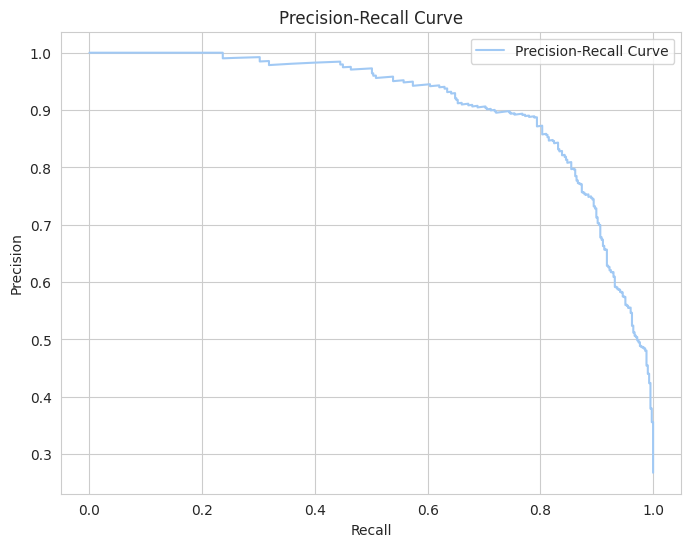

In [ ]:
# Визуализация precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

Методом подбора вывела порог равный 0.1 при котором метрика recall существенноулучшается и буду использовать для предсказания на тестовых данных

In [ ]:
optimal_threshold = 0.1

In [ ]:
# Предсказание на валидационной выборке
valid_probs = cat.predict_proba(features_valid)[:, 1]
valid_predictions = (valid_probs >= optimal_threshold).astype(int)

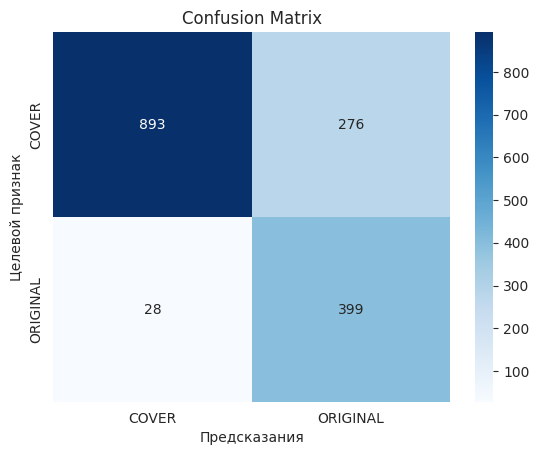

In [ ]:
cm_valid = confusion_matrix(target_valid, valid_predictions)

ax= plt.subplot()
sns.heatmap(cm_valid, annot=True, cmap='Blues', fmt='g', ax=ax)

ax.set_xlabel('Предсказания')
ax.set_ylabel('Целевой признак')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(['COVER', 'ORIGINAL'])
ax.yaxis.set_ticklabels(['COVER', 'ORIGINAL'])
plt.show()

#### Проверка на тестовых данных

In [ ]:
features_test[cat_cols] = features_test[cat_cols].astype('category')

In [ ]:
# Предсказание на тестовой выборке
test_probs = cat.predict_proba(features_test)[:, 1]
test_predictions = (test_probs >= optimal_threshold).astype(int)

# Вычисление метрик
roc_auc = roc_auc_score(target_test, test_probs)
accuracy = accuracy_score(target_test, test_predictions)

In [ ]:
print('Метрика AUC ROC для модели на тестовых данных:', roc_auc)
print('Метрика Accuracy для модели на тестовых данных:', accuracy)

Метрика AUC ROC для модели на тестовых данных: 0.951714617508402
Метрика Accuracy для модели на тестовых данных: 0.8315789473684211


In [ ]:
cm_test = confusion_matrix(target_test, test_predictions)

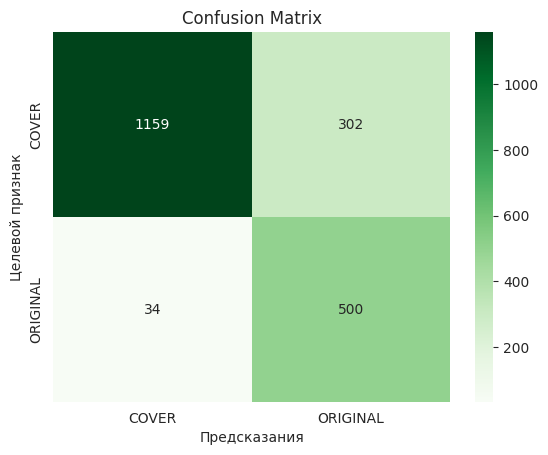

In [ ]:
ax= plt.subplot()
sns.heatmap(cm_test, annot=True, cmap='Greens', fmt='g', ax=ax)

ax.set_xlabel('Предсказания')
ax.set_ylabel('Целевой признак')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(['COVER', 'ORIGINAL'])
ax.yaxis.set_ticklabels(['COVER', 'ORIGINAL'])
plt.show()

**Вывод:**
- Модель верно предсказала, что трек является кавером (класс 0) - 1150 раз
- Модель ошибочно отнесла трек к каверу (класс 0) - 331 раз
- Модель верно предсказала оригинал трека (что является нашей основной целью)  (класс 1) - 500 раз
- Модель ошиблась в предсказании оригиналу (класс 1) - 34 раза

Таким образом, если рассмотреть отработку целевого признака - оригинал трека, то с ложноотрицательным результатом оказались лишь 6% оригинальных треков.

Метрика AUC ROC для модели на тестовых данных показала результат 0.95
Метрика Точности для модели на тестовых данных показала 0.83

Что является очень хоршим результатом

In [ ]:
feature_importance = cat.get_feature_importance()

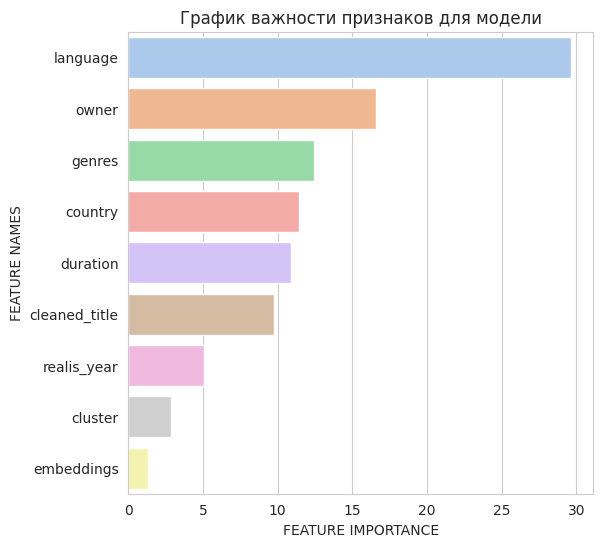

In [ ]:
def plot_feature_importance(importance,names):

    #Создание массива данных из feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Создание датафрейма и сортировка значений
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Создание графика
    plt.figure(figsize=(6,6))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title('График важности признаков для модели')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')



plot_feature_importance(feature_importance,features_train.columns)

**Вывод:** Из графика важности признаков видно, что самым ключевым для работы модели является язык трека. Как ни странно текст песни по важности модель рассматривает в последнюю очередь.

- Итого: наша моделей неплохо предсказывает вероятнотность появления оригинального трека, и теперь мы перейдем к самому интересному:

## Разработка алгоритма предложений пользователю:

- ****Проектирование алгоритма предложения каверов пользователю на основании понравившегося ему трека:****
  - пользователь выбирает трек
  - на основании имеющегося у нас кластера, включающего в себя сам оригинал и его каверы мы можем предложить:
    - самый "новый" (максимальный год релиза) кавер
    - кавер на другом языке исполнения / ковер в инструментальном исполнении
    - кавер исполненный в другом жанре(из списка имеющихся в кластере)
    - оригинал, к понравившемуся каверу
    - каверы, к понравившемуся оригиналу
- Для реализации этого алгоритма необходимо:
  - разбить датасет на кластеры с выделением оригинала (уже сделано ранее при группировке датасета по трекам и текстам)
  - создать функцию, реализующую рекомендательный алгоритм

In [ ]:
data = grouped_all_text_df.copy()

In [ ]:
data.head()

,track_id,cleaned_text,embeddings,original_track_id,track_remake_type,language,isrc,genres,duration,country,owner,realis_year,cleaned_title,cluster
0,1c4b1230f937e4c548ff732523214dcd,живу сейчас обломами обломками не той любви по...,"[0.21405859291553497, 0.0503949299454689, 0.01...",1c4b1230f937e4c548ff732523214dcd,ORIGINAL,ru,AEA0D1860569,bard,140.00,AE,A0D,2018,сарафан,1
1,0faea89b0d7d6235b5b74def72511bd8,tell me your fable a fable tell me your fable ...,"[-0.0034704282879829407, 0.07193426042795181, ...",None,COVER,en,QZS672199805,electronics,214.59,QZ,S67,2021,children,2
2,9c6dc41d5ccd9968d07f055da5d8f741,you're ashamed about all your fears and doubts...,"[-0.044518373906612396, -0.22035308182239532, ...",9c6dc41d5ccd9968d07f055da5d8f741,ORIGINAL,en,USUM71006645,rock,317.91,US,UM7,2010,briane,3
3,bfd04a73e9cffdf0e282c92219a86ea1,you're ashamed about all your fears and doubts...,"[-0.04451827332377434, -0.22035405039787292, -...",bfd04a73e9cffdf0e282c92219a86ea1,ORIGINAL,en,USM951100211,rock,317.86,US,M95,2011,briane,4
4,8d70930d09cd239c948408d1317d8659,you showed him all the best of you but i'm afr...,"[-0.07507092505693436, -0.18179209530353546, -...",8d70930d09cd239c948408d1317d8659,ORIGINAL,en,USUM71006638,rock,321.28,US,UM7,2010,broken angel,5


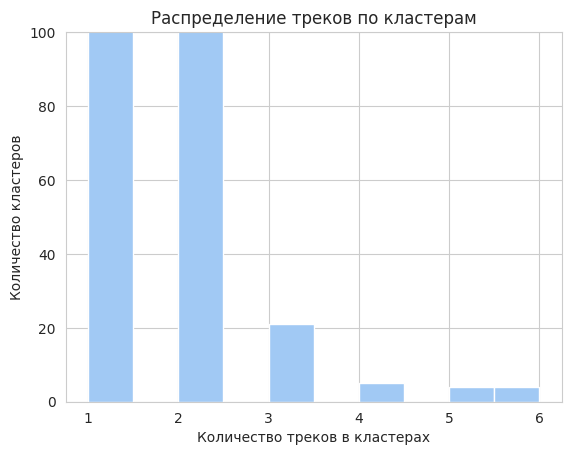

In [ ]:
plt.ylim(0, 100)
plt.xlabel('Количество треков в кластерах')
plt.ylabel('Количество кластеров')
plt.title('Распределение треков по кластерам')
data.groupby('cluster').isrc.nunique().hist();

In [ ]:
data.columns

Index(['track_id', 'cleaned_text', 'embeddings', 'original_track_id',
       'track_remake_type', 'language', 'isrc', 'genres', 'duration',
       'country', 'owner', 'realis_year', 'cleaned_title', 'cluster'],
      dtype='object')

In [ ]:
def recommend_alternatives(isrc, prefer_original=True):
    # Найдите запись с заданным isrc
    selected_record = data[data['isrc'] == isrc]

    if selected_record.empty:
        return "Запись с заданным isrc не найдена"

    # Извлеките информацию из выбранной записи
    current_genre = selected_record['genres'].values[0]
    current_language = selected_record['language'].values[0]
    current_year = selected_record['realis_year'].values[0]
    cluster_group = selected_record['cluster'].values[0]
    is_original = selected_record['track_remake_type'].values[0]


    # Фильтруйте данные, чтобы найти альтернативы внутри того же кластера
    alternatives = data[
        (data['cluster'] == cluster_group) &
        (data['isrc'] != isrc)
    ]

   # Создайте словарь для хранения рекомендаций с указанием критерия
    recommendations = {
        'newer_year': [],
        'different_genre': [],
        'different_language': [],
        'same_original_status': [],
        'opposite_original_status': []
    }

    # Предлагайте альтернативы с тем же названием и более поздним годом
    newer_versions = alternatives[alternatives['realis_year'] == alternatives['realis_year'].max()]
    if not newer_versions.empty:
        recommendations['newer_year'] = newer_versions['isrc'].tolist()

    # Предлагайте альтернативы с разными жанрами
    different_genres = alternatives[alternatives['genres'] != current_genre]
    if not different_genres.empty:
        recommendations['different_genre'] = different_genres['isrc'].tolist()

    # Предлагайте альтернативы на других языках
    different_languages = alternatives[alternatives['language'] != current_language]
    if not different_languages.empty:
        recommendations['different_language'] = different_languages['isrc'].tolist()

    # Предлагайте альтернативы с тем же статусом "оригинал vs. кавер" и противоположным статусом
    same_original_status = alternatives[alternatives['track_remake_type'] == is_original]
    opposite_original_status = alternatives[alternatives['track_remake_type'] != is_original]
    if not same_original_status.empty:
        recommendations['same_original_status'] = same_original_status['isrc'].tolist()
    if not opposite_original_status.empty:
        recommendations['opposite_original_status'] = opposite_original_status['isrc'].tolist()


    if not any(recommendations.values()):
        return "Нет альтернатив для заданной записи"

    return recommendations

In [ ]:
tracks_in_cluster_9507 = data[data['cluster'] == 9507]
tracks_in_cluster_9507

,track_id,cleaned_text,embeddings,original_track_id,track_remake_type,language,isrc,genres,duration,country,owner,realis_year,cleaned_title,cluster
9736,e46055b455d3f10cf1cdf6e6e96ed747,kiss me hard before you go summertime sadness ...,"[-0.14125888049602509, 0.004225661978125572, -...",None,COVER,en,ES20I1175611,pop,203.60,ES,20I,2011,balada boa,9507
9737,b9f2e66fec794676e8c8bc45e9f37815,kiss me hard before you go summertime sadness ...,"[-0.14125888049602509, 0.004225661978125572, -...",None,COVER,en,ES20I1177701,pop,203.54,ES,20I,2011,balada boa,9507
9738,750e5414bb48eceb1ad1e1b272cc7e66,kiss me hard before you go summertime sadness ...,"[-0.14125888049602509, 0.004225661978125572, -...",None,COVER,en,ES20I1177615,pop,203.54,ES,20I,2011,balada boa,9507
9739,da6d53f4766cdb60983274dc3dee4a11,kiss me hard before you go summertime sadness ...,"[-0.14125888049602509, 0.004225661978125572, -...",None,COVER,en,ES20I1178807,pop,203.60,ES,20I,2011,balada boa,9507
9740,1db4f8ce6b141bb680fbd0a0e3067168,kiss me hard before you go summertime sadness ...,"[-0.14125888049602509, 0.004225661978125572, -...",None,COVER,en,ES64A1038303,pop,203.60,ES,64A,2010,balada boa,9507
9741,a80131768970c58da16e038cab768cee,kiss me hard before you go summertime sadness ...,"[-0.14125888049602509, 0.004225661978125572, -...",None,COVER,en,ES64A1037009,pop,203.60,ES,64A,2010,balada boa,9507


In [ ]:
# Пример использования функции
isrc_to_recommend = 'ES20I1175611'
recommended_alternatives = recommend_alternatives(isrc_to_recommend)
if recommended_alternatives == "Нет альтернатив для заданной записи":
    print("Нет альтернатив для", isrc_to_recommend)
else:
    for criterion, isrc_list in recommended_alternatives.items():
        if isrc_list:
            print("Рекомендации по критерию", criterion, "для", isrc_to_recommend, ":", isrc_list)

Рекомендации по критерию newer_year для ES20I1175611 : ['ES20I1177701', 'ES20I1177615', 'ES20I1178807']
Рекомендации по критерию same_original_status для ES20I1175611 : ['ES20I1177701', 'ES20I1177615', 'ES20I1178807', 'ES64A1038303', 'ES64A1037009']


## ВЫВОД

Была проведена работа по решению задачи классификации (определения класса оригинального трека из имеющегося набора оригиналов и каверов) и предложена модель рекомендации клиенту.

В ходе работы был проведен анализ и предобработка имеющегося датасета:
    
- проведена работа с пропусками и дубликатами в данных, изменение типов данных
- объединение данных в общий датасет
- предобработка текстовых данных(текстов, названий, жанров треков);
- были сгенерированы новые признаки из имеющегося уникального isrc кода
- закодированы тексты песен в эмбеддинги, для того, чтобы найти каверы на других языках
- для того, чтобы сделать систему предложения для клиента сделала группировку с помощью метод сравнения косинусного растояния между текстами треков.


Свою работу я решила сфокусировать на анализе тех треков, к которым в датасете имеются тексты, а треки, к которым тексты не были подгружены, пока в работе не рассматривать.



- проведено обучение, валидация и тестирование модели-классификатора. Для работы я выбрала модель CatBoost,так как она умеет напрямую без кодирования работать как с текстами, так и с эмбеддингами, в которые тексты были предварительно закодированы. Если рассмотреть как  показатель качества модели то, как хорошо она обнаружила оригиналы треков, то с ложноотрицательным результатом оказались лишь 6% оригинальных треков (помечены как каверы, хотя являлись оригиналами). Метрика Точности для модели на тестовых данных показала 0.83

- спроектирован алгоритм рекомендательной системы по выбору треков для конечного пользователя продукта: Так например на основе понравившегося трека пользователю можно предложить на выбор:
   - самый "новый" (максимальный год релиза) кавер
   - кавер на другом языке исполнения / ковер в инструментальном исполнении
   - кавер исполненный в другом жанре(из списка имеющихся в кластере)
   - оригинал, к понравившемуся каверу
   - каверы, к понравившемуся оригиналу
  

**Рекомендации по подготовке данных**:
В дальнейшем полезно было бы добавить для анализа информацию об исполнителе трека, подгрузить больше текстов для более корректного анализа. Обязательно нужно проверить разметку треков на оригинал и кавер, из-за того, что оригинал часто отсутствует в датасете, возможно стоит произвести разметку тректов внутри кластеров по самому раннему году релиза и присвоить ему метку оригинала.